## Data Cleaning

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

application = pd.read_csv('/Users/henryzeng/Desktop/UWO Courses/Banking Analytics/Project 2/coursework2_datasets/coursework2_application_sampled.csv')
performance = pd.read_csv('/Users/henryzeng/Desktop/UWO Courses/Banking Analytics/Project 2/coursework2_datasets/coursework2_performance_data_sampled.csv')

# merge the data from the two csvs
data_full = performance.merge(application, on='LOAN SEQUENCE NUMBER', how='left')

# change monthly reoprting period to datetime
data_full['MONTHLY REPORTING PERIOD'] = pd.to_datetime(data_full['MONTHLY REPORTING PERIOD'], format='%Y%m')

# if column value is RA then it is 3
data_full['CURRENT LOAN DELINQUENCY STATUS'] = data_full['CURRENT LOAN DELINQUENCY STATUS'].apply(lambda x: 3 if x == 'RA' else x)

# change to int
data_full['CURRENT LOAN DELINQUENCY STATUS'] = data_full['CURRENT LOAN DELINQUENCY STATUS'].astype(int)
# change the column CURRENT LOAN DELINQUENCY STATUS
# slide 13 4 intro to analytics
# if value is less then 3 then it is 0 # else it is 1 # zero represents no default # one represents default
data_full['DEFAULT'] = data_full['CURRENT LOAN DELINQUENCY STATUS'].apply(lambda x: 0 if x < 3 else 1)

########### data cleaning ###########
# if zero balance code is 1 then remove the row
data_full = data_full[~(data_full['ZERO BALANCE CODE'] == 1)]

# remove the rows where CURRENT ACTUAL UPB is 0
data_full = data_full[~(data_full['CURRENT ACTUAL UPB'] == 0)]

data_full['CUMULATIVE MODIFICATION COST'].fillna(0, inplace=True)
data_full['STEP MODIFICATION FLAG'].fillna('Not modified', inplace=True)
data_full['PAYMENT DEFERRAL'].fillna('Not payment deferral', inplace=True)
data_full['DELINQUENT ACCRUED INTEREST'].fillna(0, inplace=True)
data_full['DELINQUENCY DUE TO DISASTER'].fillna('N', inplace=True)
data_full['BORROWER ASSISTANCE STATUS CODE'].fillna('N', inplace=True)
data_full['CURRENT MONTH MODIFICATION COST'].fillna(0, inplace=True)
data_full['RELIEF REFINANCE INDICATOR'].fillna('N', inplace=True)
data_full['SUPER CONFORMING FLAG'].fillna('N', inplace=True)
data_full['METROPOLITAN STATISTICAL AREA (MSA) OR METROPOLITAN DIVISION'].fillna('unknown', inplace=True)

# drop DEFECT SETTLEMENT DATE
data_full.drop(columns=['DEFECT SETTLEMENT DATE'], inplace=True)

# drop the columns with more than 90% missing values
data_full = data_full.loc[:, data_full.isnull().mean() <= 0.9]

# drop the rows with all 0 values
data_full = data_full.loc[:, (data_full != 0).any(axis=0)]

# Replace specific missing values with 'np.nan'
missing_value_map = {
    'CREDIT SCORE': [9999],
    'FIRST TIME HOMEBUYER FLAG': [9],
    'MI PERCENT': [999],
    'NUMBER OF UNITS': [99],
    'OCCUPANCY STATUS': [9],
    'ORIGINAL CLTV': [999],
    'ORIGINAL DTI RATIO': [999],
    'ORIGINAL LTV': [999],
    'CHANNEL': [9],
    'PROPERTY TYPE': [99],
    'LOAN PURPOSE': [9],
    'NUMBER OF BORROWERS': [99],
    'PROGRAM INDICATOR': [9],
    'PROPERTY VALUATION METHOD': [9],
    'MI CANCELLATION INDICATOR': [9, 7]
}

for column, values in missing_value_map.items():
    if column in data_full.columns:
        data_full[column] = data_full[column].replace(values, np.nan)


# List of columns to convert to datetime
date_columns = [
    'MONTHLY REPORTING PERIOD', 
    'FIRST PAYMENT DATE', 
    'MATURITY DATE'
]

# Convert the specified columns to datetime
for column in date_columns:
    if column in data_full.columns:
        data_full[column] = pd.to_datetime(data_full[column], errors='coerce')

###### feature engineering ########

# add boolean for whether loan in delinquency or not 
data_full['DELINQUENCY'] = data_full['CURRENT LOAN DELINQUENCY STATUS'].apply(lambda x : 1 if x != 0 else 0)

# cum sum of the delinquency status
data_full['DEFAULT CUM SUM'] = data_full.groupby('LOAN SEQUENCE NUMBER')['DEFAULT'].cumsum()

# last month current loan deliquency status
data_full['LAST MONTH DELINQUENCY STATUS'] = data_full.groupby('LOAN SEQUENCE NUMBER')['CURRENT LOAN DELINQUENCY STATUS'].shift(1).fillna(0)

# rolling 12 months time in deliquency
data_full['MONTHS IN DELINQUENCY PAST 12'] = data_full.groupby('LOAN SEQUENCE NUMBER')['DELINQUENCY'].rolling(12, min_periods=1).sum().reset_index(drop=True)

# make a function that takes in a pd.series of zeroes and ones and then returns a new series with every 12 before the ones being ones as well
def default_next_12(default_vector):
     
    if np.where(default_vector==1)[0].size==0:
        return default_vector
     
    first_default = np.where(default_vector==1)[0][0]
    defualt_next_12_vector = np.zeros(len(default_vector))
    defualt_next_12_vector[max(0,first_default-12):] = 1

    return(defualt_next_12_vector)

default_next_12_col = []

# group the data by LOAN SEQUENCE NUMBER
for _, group in data_full.groupby('LOAN SEQUENCE NUMBER'):
    default_next_12_series = default_next_12(group['DEFAULT'])

    default_next_12_col.extend(default_next_12_series)

data_full['DEFAULT_NEXT_12'] = [x == 1 for x in default_next_12_col]

# remove rows where the cumsum != 0
data_full = data_full[data_full['DEFAULT CUM SUM'] == 0]

# make training data
data_full_train = data_full[data_full['MONTHLY REPORTING PERIOD'] < '2022-06-01']

# make out of time data
data_full_oot = data_full[data_full['MONTHLY REPORTING PERIOD'] == '2023-06-01']

data_full.head()

,LOAN SEQUENCE NUMBER,MONTHLY REPORTING PERIOD,CURRENT ACTUAL UPB,CURRENT LOAN DELINQUENCY STATUS,LOAN AGE,REMAINING MONTHS TO LEGAL MATURITY,CURRENT INTEREST RATE,CURRENT NON-INTEREST BEARING UPB,CUMULATIVE MODIFICATION COST,STEP MODIFICATION FLAG,...,RELIEF REFINANCE INDICATOR,PROPERTY VALUATION METHOD,INTEREST ONLY INDICATOR (I/O INDICATOR),MI CANCELLATION INDICATOR,DEFAULT,DELINQUENCY,DEFAULT CUM SUM,LAST MONTH DELINQUENCY STATUS,MONTHS IN DELINQUENCY PAST 12,DEFAULT_NEXT_12
0,F14Q10000351,2021-01-01,194781.21,0,83,277,4.75,0.0,0.0,Not modified,...,N,NaN,N,9,0,0,0,0.0,0.0,False
1,F14Q10000351,2021-02-01,194383.73,0,84,276,4.75,0.0,0.0,Not modified,...,N,NaN,N,9,0,0,0,0.0,0.0,False
2,F14Q10000351,2021-03-01,193984.68,0,85,275,4.75,0.0,0.0,Not modified,...,N,NaN,N,9,0,0,0,0.0,0.0,False
3,F14Q10000351,2021-04-01,193584.05,0,86,274,4.75,0.0,0.0,Not modified,...,N,NaN,N,9,0,0,0,0.0,0.0,False
4,F14Q10000351,2021-05-01,193181.83,0,87,273,4.75,0.0,0.0,Not modified,...,N,NaN,N,9,0,0,0,0.0,0.0,False


In [30]:
from sklearn.model_selection import train_test_split

# Split the data into features and target
X = data_full_train.drop(columns=['DEFAULT_NEXT_12', 'MONTHLY REPORTING PERIOD', 'LOAN SEQUENCE NUMBER',
                                  'DEFAULT', 'DEFAULT CUM SUM', 'MATURITY DATE', 'SELLER NAME', 'FIRST PAYMENT DATE', 'SERVICER NAME',
                                  'DELINQUENCY'])
y = data_full_train['DEFAULT_NEXT_12']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

data_full['NUMBER OF UNITS'] = data_full['NUMBER OF UNITS'].astype(float)
data_full['NUMBER OF BORROWERS'] = data_full['NUMBER OF BORROWERS'].astype(float)

## Weight of Evidence

In [32]:
ordered_vars = [
    'CREDIT SCORE',
    'ORIGINAL UPB',
    'ORIGINAL INTEREST RATE',
    'ORIGINAL LOAN-TO-VALUE (LTV)',
    'ORIGINAL COMBINED LOAN-TO-VALUE (CLTV)',
    'ORIGINAL DEBT-TO-INCOME (DTI) RATIO',
    'ORIGINAL LOAN TERM',
    'MORTGAGE INSURANCE PERCENTAGE (MI %)',
    'ESTIMATED LOAN TO VALUE (ELTV)',
    'CURRENT ACTUAL UPB',
    'CURRENT INTEREST RATE',
    'INTEREST BEARING UPB',
    'CURRENT NON-INTEREST BEARING UPB',
    'CUMULATIVE MODIFICATION COST',
    'LOAN AGE',
    'REMAINING MONTHS TO LEGAL MATURITY',
    'NUMBER OF UNITS',
    'NUMBER OF BORROWERS'
]

# find out ordered_vars that with all 0 rows
zero_cols_in_ordered = [
    col for col in ordered_vars
    if col in data_full.columns and (data_full[col] == 0).all()
]

if zero_cols_in_ordered:
    print("The following ordered variables are all zeros and may be removed:")
    print(zero_cols_in_ordered)
else:
    print("✅ None of the ordered_vars are all-zero columns.")

✅ None of the ordered_vars are all-zero columns.


In [34]:
import scorecardpy as sc
import sys
import matplotlib.pyplot as plt
import seaborn as sns

# combine X and y to make a new dataframe
X_train = pd.concat([X_train, y_train], axis=1)

X_train_bin = X_train[ordered_vars + ['DEFAULT_NEXT_12']].copy()

breaks_list = {
    'NUMBER OF UNITS': [2.5, 3, 3.5],
    'CURRENT NON-INTEREST BEARING UPB': [2000,4000]
}

bins = sc.woebin(X_train_bin, y='DEFAULT_NEXT_12',
                 min_perc_fine_bin=0.02, # How many bins to cut initially into
                 min_perc_coarse_bin=0.05,  # Minimum percentage per final bin
                 stop_limit=0.02, # Minimum information value
                 max_num_bin=8, # Maximum number of bins
                 method='tree',
                 breaks_list=breaks_list
                 )

#ignore the warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

class HideStderr:
    def __enter__(self):
        self.stderr_fileno = sys.stderr
        self.null = open(os.devnull, 'w')
        sys.stderr = self.null
    def __exit__(self, *args):
        sys.stderr = self.stderr_fileno

with HideStderr():
    bins = sc.woebin(data_full[['X_train_bin', 'DEFAULT_NEXT_12']], y='DEFAULT_NEXT_12')

[INFO] creating woe binning ...


/opt/anaconda3/lib/python3.12/site-packages/scorecardpy/woebin.py:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .stack().replace('missing', np.nan) \
/opt/anaconda3/lib/python3.12/site-packages/scorecardpy/woebin.py:320: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  init_bin = dtm.groupby('bin', group_keys=False)['y'].agg([n0, n1])\
/opt/anaconda3/lib/python3.12/site-packages/scorecardpy/woebin.py:141: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used d

KeyError: "['X_train_bin'] not in index"

In [119]:
print(data_full['NUMBER OF UNITS'].value_counts(dropna=False))
print(data_full['CURRENT NON-INTEREST BEARING UPB'].value_counts(dropna=False))

NUMBER OF UNITS
1.0    1639127
2.0      21919
4.0       5987
3.0       5509
Name: count, dtype: int64
CURRENT NON-INTEREST BEARING UPB
0.00        1659549
2910.92          42
2062.44          42
2570.37          42
9459.90          42
             ...   
7058.70           1
11900.28          1
4627.14           1
4915.28           1
8837.83           1
Name: count, Length: 631, dtype: int64


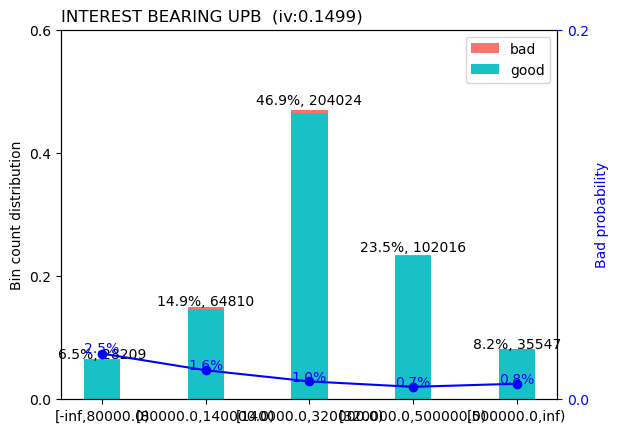

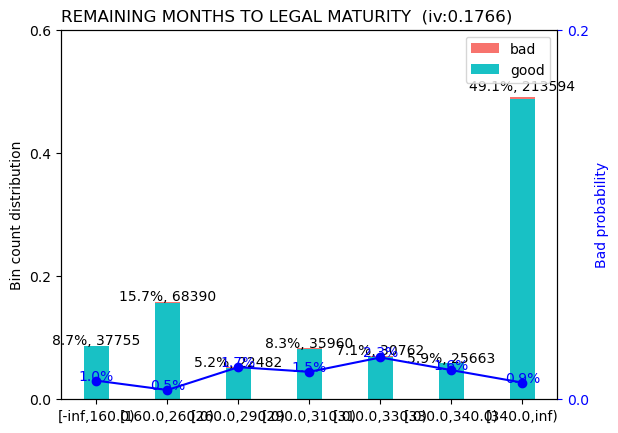

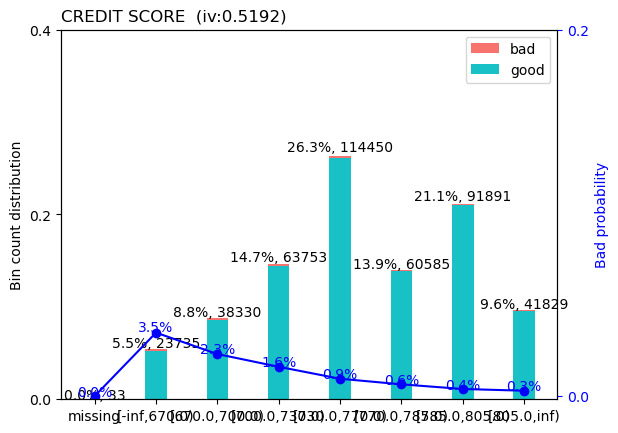

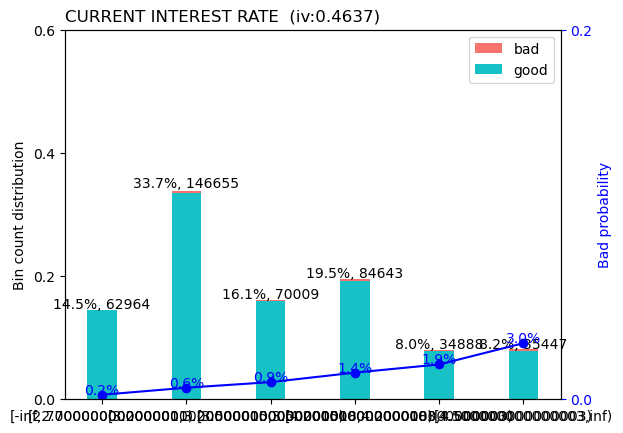

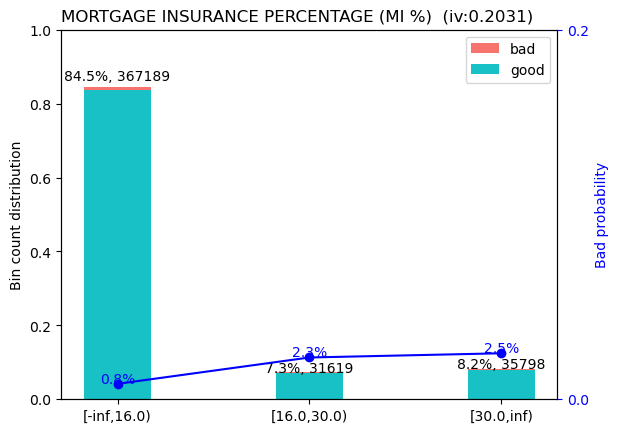

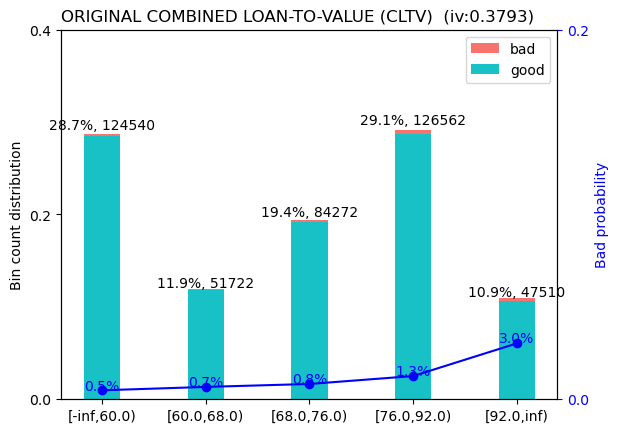

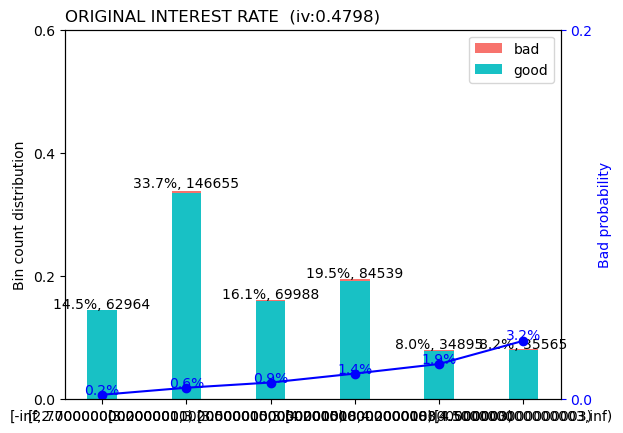

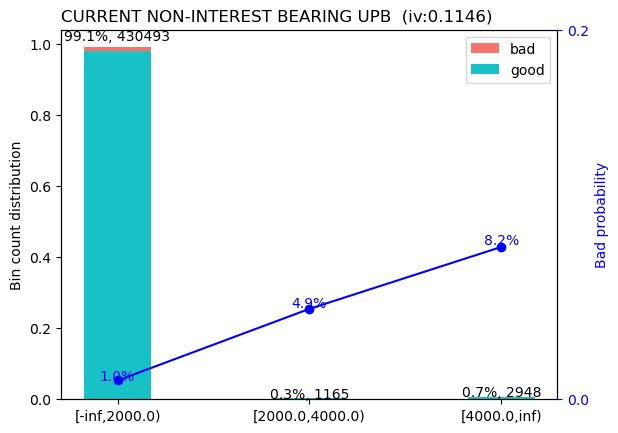

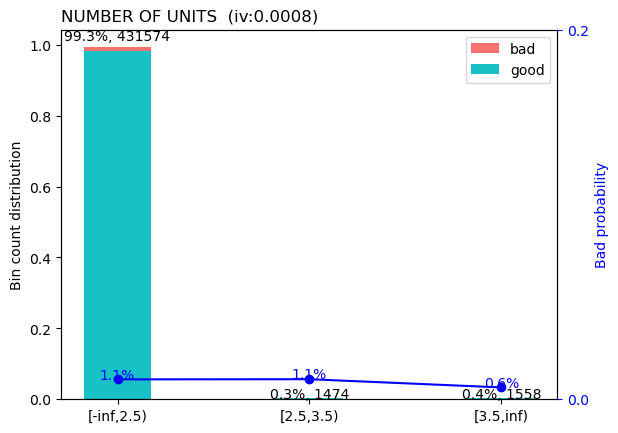

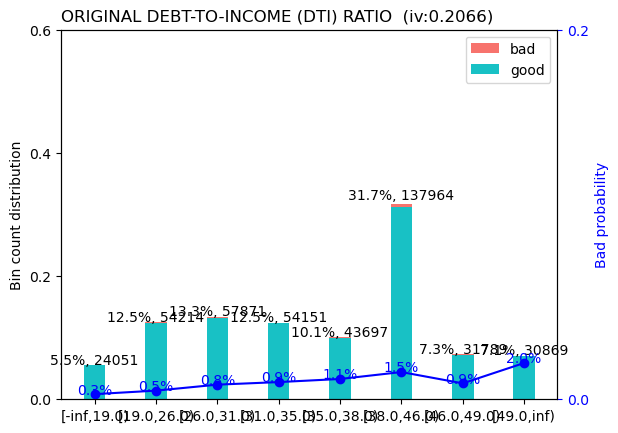

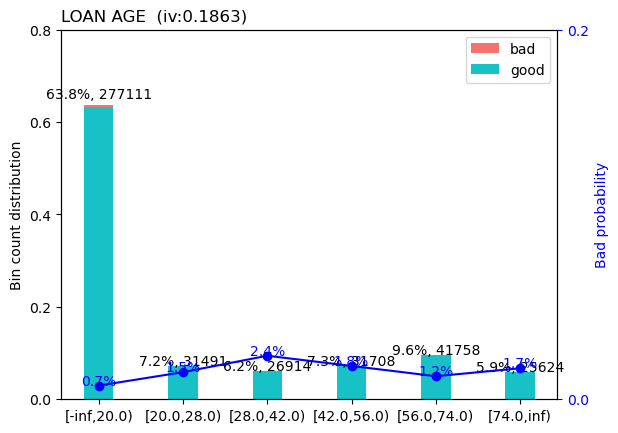

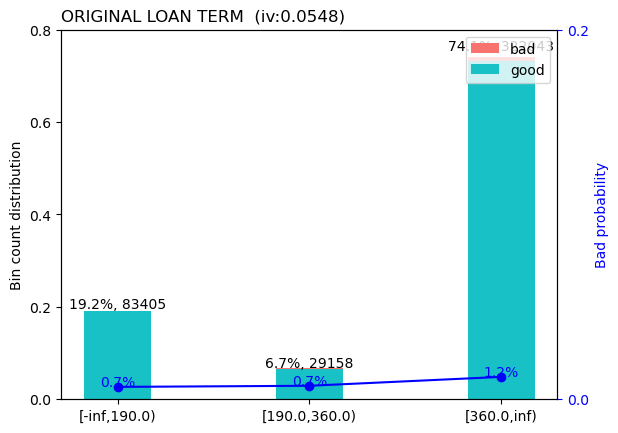

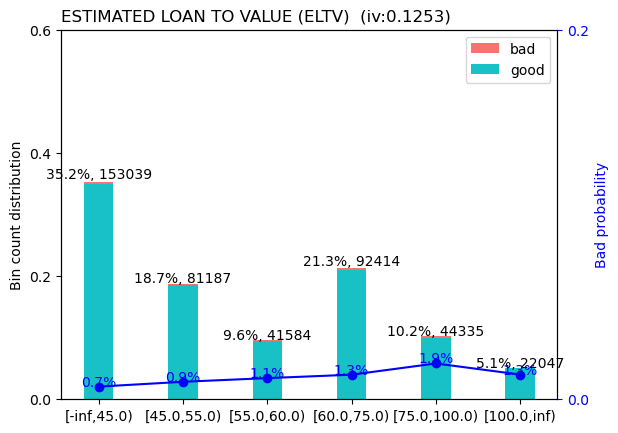

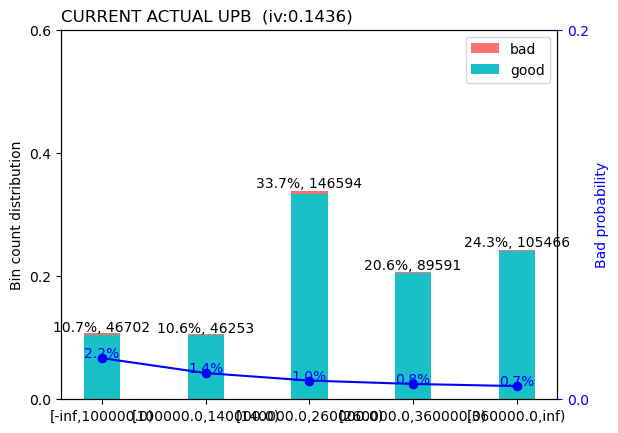

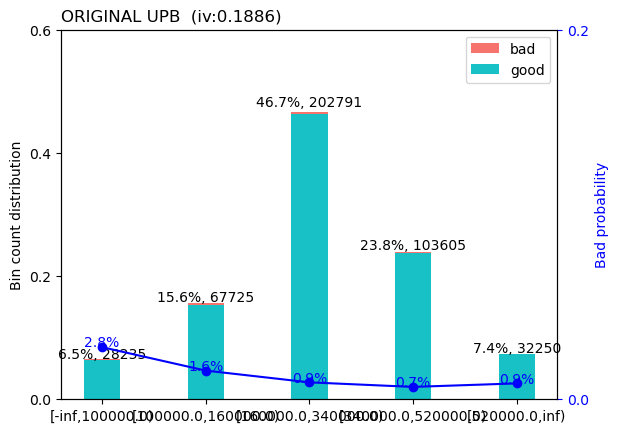

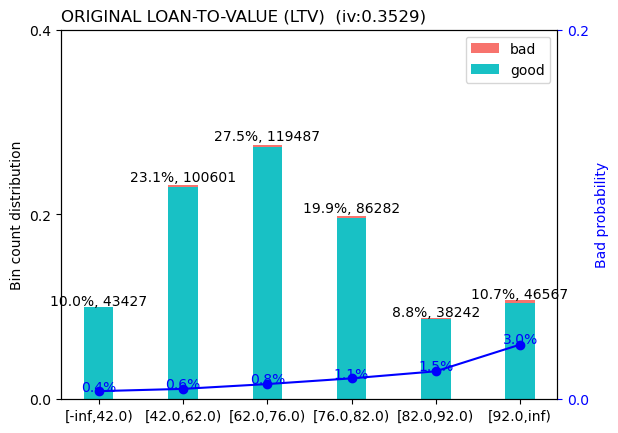

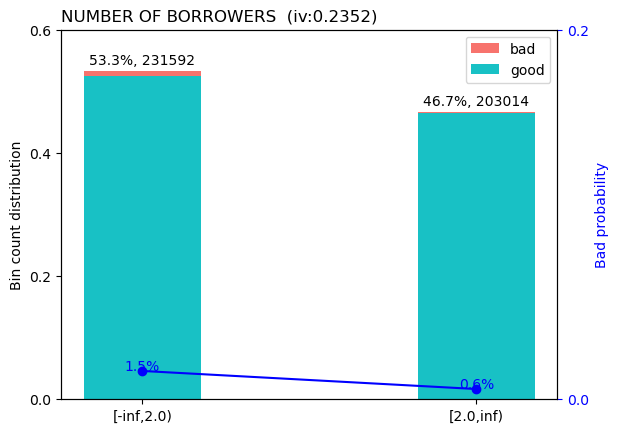

{'INTEREST BEARING UPB':                variable                  bin   count  count_distr    good  \
 0  INTEREST BEARING UPB       [-inf,80000.0)   28209     0.064907   27512   
 1  INTEREST BEARING UPB   [80000.0,140000.0)   64810     0.149124   63793   
 2  INTEREST BEARING UPB  [140000.0,320000.0)  204024     0.469446  202049   
 3  INTEREST BEARING UPB  [320000.0,500000.0)  102016     0.234732  101329   
 4  INTEREST BEARING UPB       [500000.0,inf)   35547     0.081791   35248   
 
     bad   badprob       woe    bin_iv  total_iv    breaks  is_special_values  
 0   697  0.024708  0.845803  0.071977  0.149894   80000.0              False  
 1  1017  0.015692  0.382609  0.026461  0.149894  140000.0              False  
 2  1975  0.009680 -0.106546  0.005061  0.149894  320000.0              False  
 3   687  0.006734 -0.472398  0.041918  0.149894  500000.0              False  
 4   299  0.008411 -0.248325  0.004477  0.149894       inf              False  ,
 'REMAINING MONTHS TO LEG

In [36]:
sc.woebin_plot(bins)
plt.show()

bins

-------- 1/17 INTEREST BEARING UPB --------
>>> dt[INTEREST BEARING UPB].describe(): 
count    4.346060e+05
mean     2.682419e+05
std      1.532707e+05
min      1.800000e-01
25%      1.520000e+05
50%      2.397790e+05
75%      3.557791e+05
max      1.337000e+06
Name: INTEREST BEARING UPB, dtype: float64 



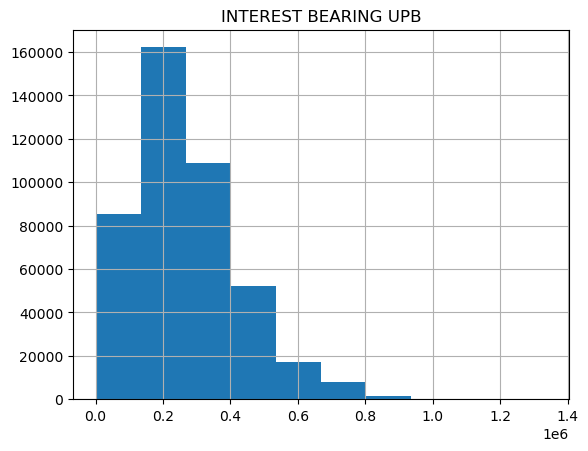

>>> Current breaks:
80000.0,140000.0,320000.0,500000.0 



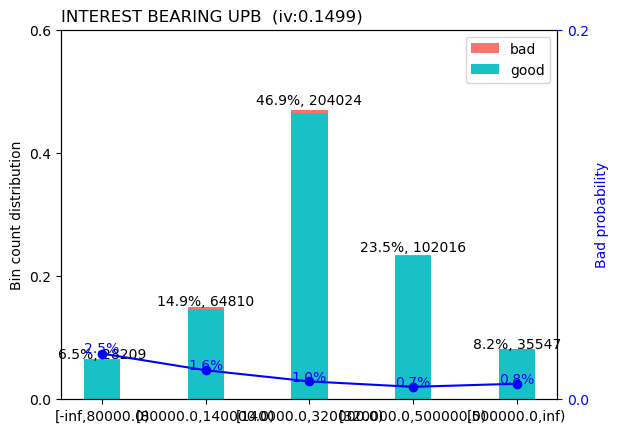

>>> Adjust breaks for (1/17) INTEREST BEARING UPB?
1: next 
2: yes 
3: back


Selection:  1


-------- 2/17 REMAINING MONTHS TO LEGAL MATURITY --------
>>> dt[REMAINING MONTHS TO LEGAL MATURITY].describe(): 
count    434606.000000
mean        294.359811
std          79.994751
min          23.000000
25%         271.000000
50%         339.000000
75%         352.000000
max         479.000000
Name: REMAINING MONTHS TO LEGAL MATURITY, dtype: float64 



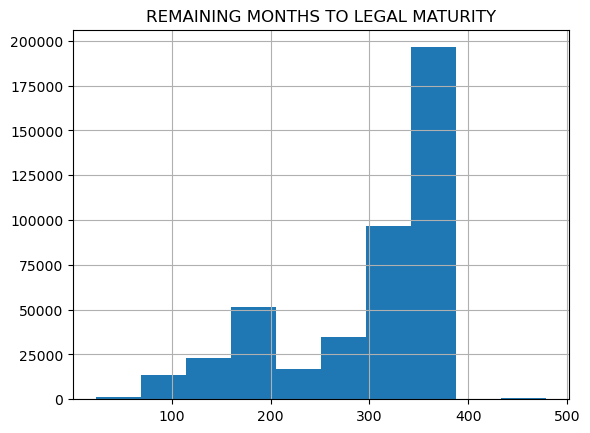

>>> Current breaks:
160.0,260.0,290.0,310.0,330.0,340.0 



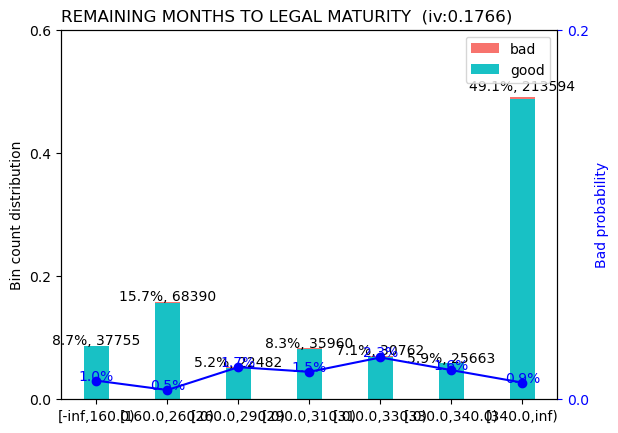

>>> Adjust breaks for (2/17) REMAINING MONTHS TO LEGAL MATURITY?
1: next 
2: yes 
3: back


Selection:  2
>>> Enter modified breaks:  260.0,290.0,310.0,330.0


[INFO] creating woe binning ...
>>> Current breaks:
310.0, 330.0, 260.0, 290.0 



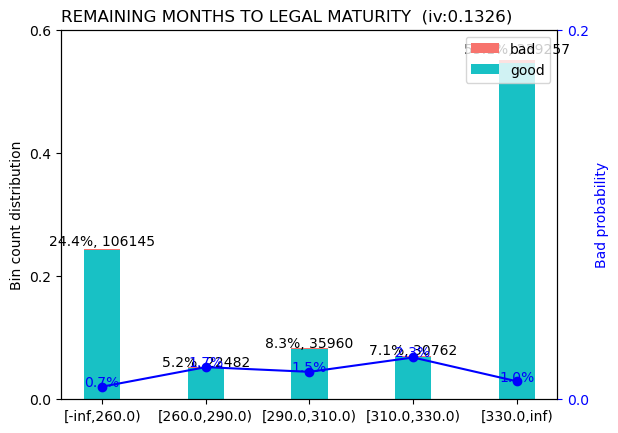

>>> Adjust breaks for (2/17) REMAINING MONTHS TO LEGAL MATURITY?
1: next 
2: yes 
3: back


Selection:  2
>>> Enter modified breaks:  260.0,290.0,310.0


[INFO] creating woe binning ...
>>> Current breaks:
310.0, 290.0, 260.0 



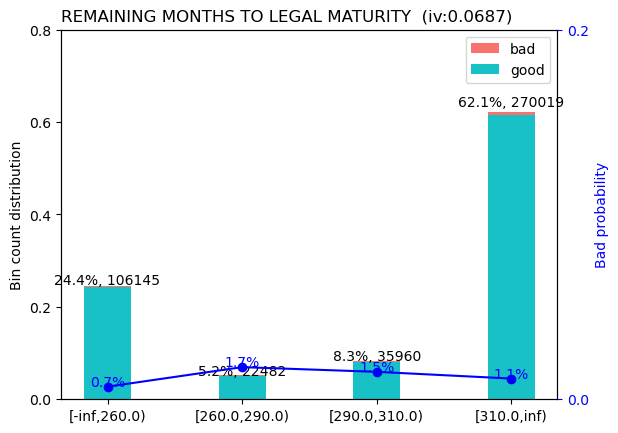

>>> Adjust breaks for (2/17) REMAINING MONTHS TO LEGAL MATURITY?
1: next 
2: yes 
3: back


Selection:  2
>>> Enter modified breaks:  300，310


>>> Adjust breaks for (2/17) REMAINING MONTHS TO LEGAL MATURITY?
1: next 
2: yes 
3: back


Selection:  2
>>> Enter modified breaks:  300，310，320


>>> Adjust breaks for (2/17) REMAINING MONTHS TO LEGAL MATURITY?
1: next 
2: yes 
3: back


Selection:  3


-------- 1/17 INTEREST BEARING UPB --------
>>> dt[INTEREST BEARING UPB].describe(): 
count    4.346060e+05
mean     2.682419e+05
std      1.532707e+05
min      1.800000e-01
25%      1.520000e+05
50%      2.397790e+05
75%      3.557791e+05
max      1.337000e+06
Name: INTEREST BEARING UPB, dtype: float64 



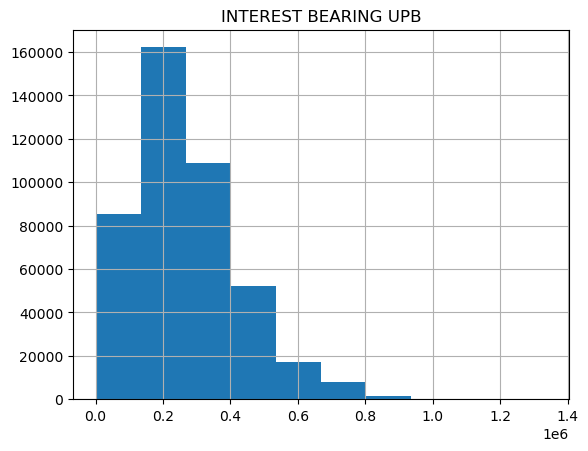

>>> Current breaks:
80000.0,140000.0,320000.0,500000.0 



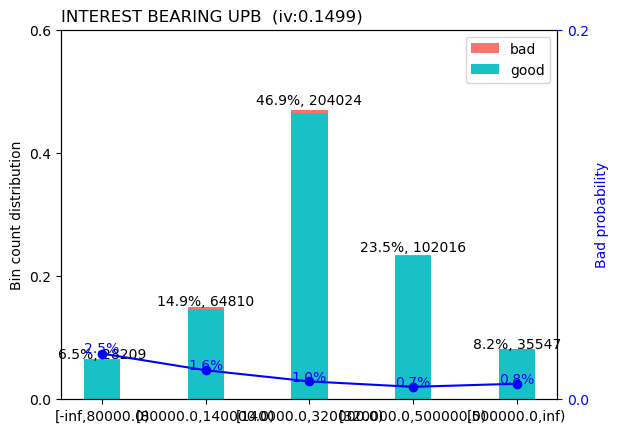

>>> Adjust breaks for (1/17) INTEREST BEARING UPB?
1: next 
2: yes 
3: back


Selection:  2
>>> Enter modified breaks:  80000.0,140000.0,320000


[INFO] creating woe binning ...
>>> Current breaks:
80000.0, 140000.0, 320000.0 



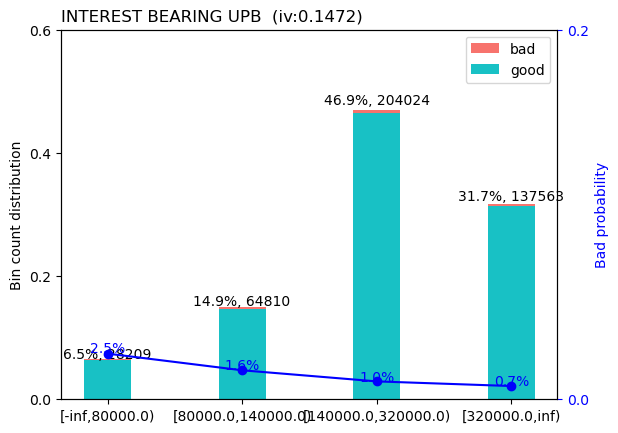

>>> Adjust breaks for (1/17) INTEREST BEARING UPB?
1: next 
2: yes 
3: back


Selection:  1


-------- 2/17 REMAINING MONTHS TO LEGAL MATURITY --------
>>> dt[REMAINING MONTHS TO LEGAL MATURITY].describe(): 
count    434606.000000
mean        294.359811
std          79.994751
min          23.000000
25%         271.000000
50%         339.000000
75%         352.000000
max         479.000000
Name: REMAINING MONTHS TO LEGAL MATURITY, dtype: float64 



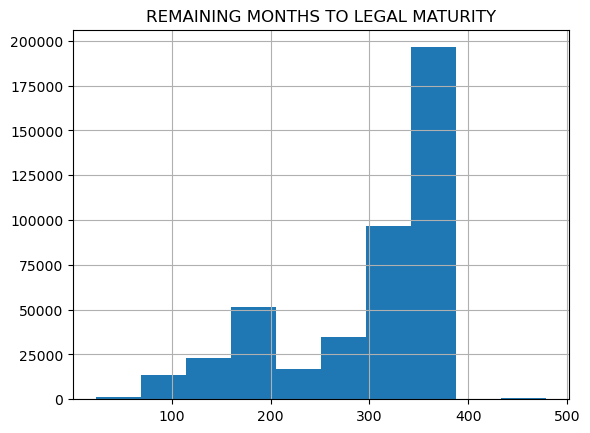

>>> Current breaks:
160.0,260.0,290.0,310.0,330.0,340.0 



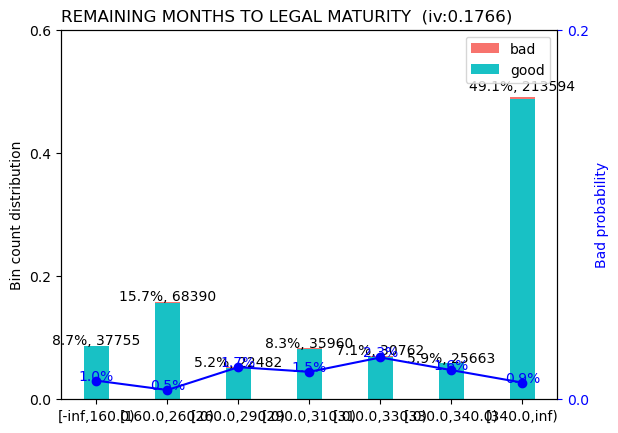

>>> Adjust breaks for (2/17) REMAINING MONTHS TO LEGAL MATURITY?
1: next 
2: yes 
3: back


Selection:  2
>>> Enter modified breaks:  290.0,310.0,330.0,340.0 


[INFO] creating woe binning ...
>>> Current breaks:
340.0, 310.0, 330.0, 290.0 



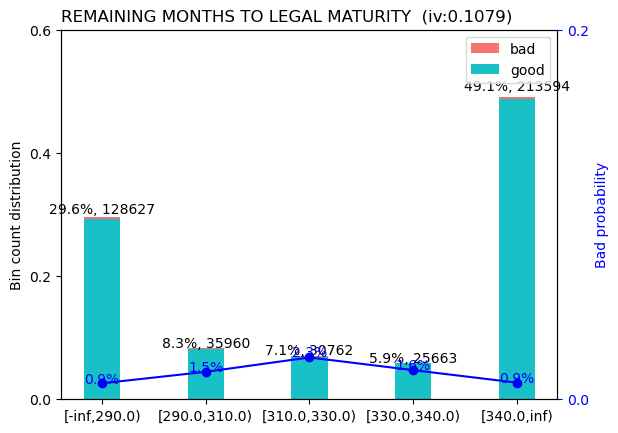

>>> Adjust breaks for (2/17) REMAINING MONTHS TO LEGAL MATURITY?
1: next 
2: yes 
3: back


Selection:  2
>>> Enter modified breaks:  320.0,330.0,340.0 


[INFO] creating woe binning ...
>>> Current breaks:
320.0, 340.0, 330.0 



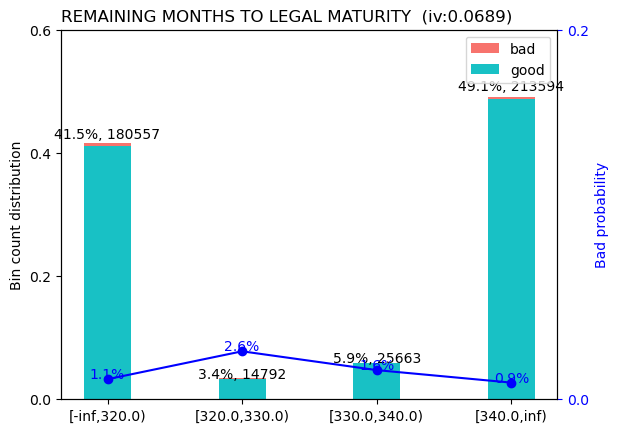

>>> Adjust breaks for (2/17) REMAINING MONTHS TO LEGAL MATURITY?
1: next 
2: yes 
3: back


Selection:  3


-------- 1/17 INTEREST BEARING UPB --------
>>> dt[INTEREST BEARING UPB].describe(): 
count    4.346060e+05
mean     2.682419e+05
std      1.532707e+05
min      1.800000e-01
25%      1.520000e+05
50%      2.397790e+05
75%      3.557791e+05
max      1.337000e+06
Name: INTEREST BEARING UPB, dtype: float64 



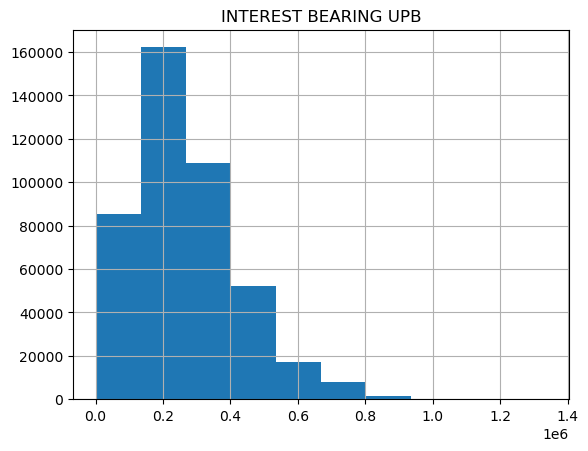

>>> Current breaks:
80000.0,140000.0,320000 



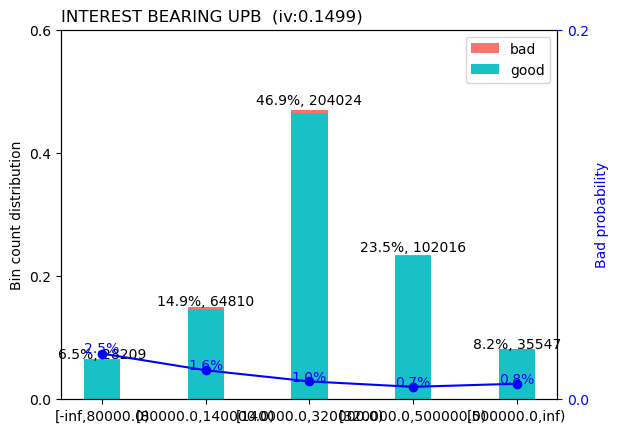

>>> Adjust breaks for (1/17) INTEREST BEARING UPB?
1: next 
2: yes 
3: back


Selection:  2
>>> Enter modified breaks:  80000.0,140000.0,320000 


[INFO] creating woe binning ...
>>> Current breaks:
80000.0, 140000.0, 320000.0 



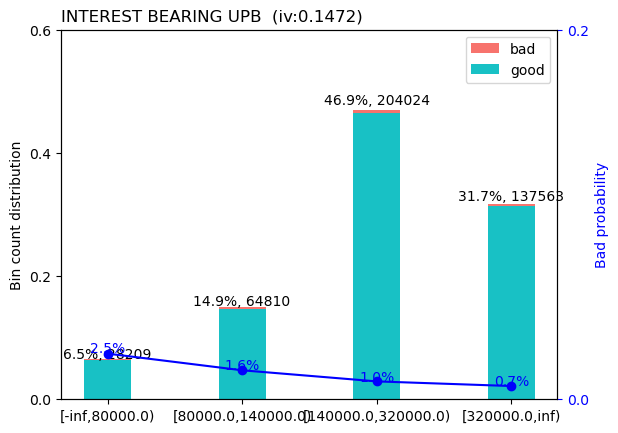

>>> Adjust breaks for (1/17) INTEREST BEARING UPB?
1: next 
2: yes 
3: back


Selection:  1


-------- 2/17 REMAINING MONTHS TO LEGAL MATURITY --------
>>> dt[REMAINING MONTHS TO LEGAL MATURITY].describe(): 
count    434606.000000
mean        294.359811
std          79.994751
min          23.000000
25%         271.000000
50%         339.000000
75%         352.000000
max         479.000000
Name: REMAINING MONTHS TO LEGAL MATURITY, dtype: float64 



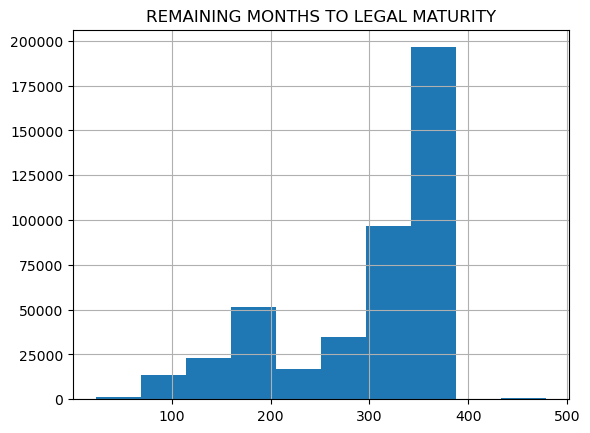

>>> Current breaks:
160.0,260.0,290.0,310.0,330.0,340.0 



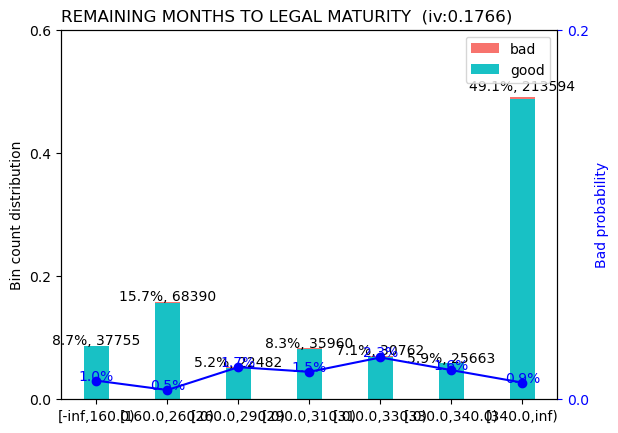

>>> Adjust breaks for (2/17) REMAINING MONTHS TO LEGAL MATURITY?
1: next 
2: yes 
3: back


Selection:  260.0,290.0,310.0,330.0,340.0 


Input could not be converted to digit.


Selection:  2
>>> Enter modified breaks:  260.0,290.0,310.0,330.0,340.0 


[INFO] creating woe binning ...
>>> Current breaks:
340.0, 330.0, 260.0, 290.0, 310.0 



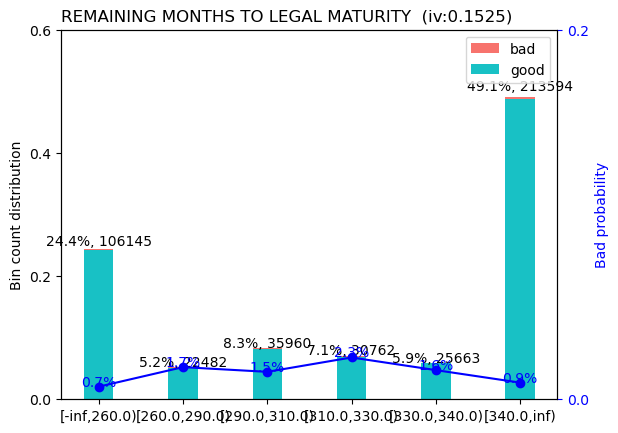

>>> Adjust breaks for (2/17) REMAINING MONTHS TO LEGAL MATURITY?
1: next 
2: yes 
3: back


Selection:  2
>>> Enter modified breaks:  260.0,280.0,310.0,330.0,340.0 


[INFO] creating woe binning ...
>>> Current breaks:
340.0, 330.0, 260.0, 310.0, 280.0 



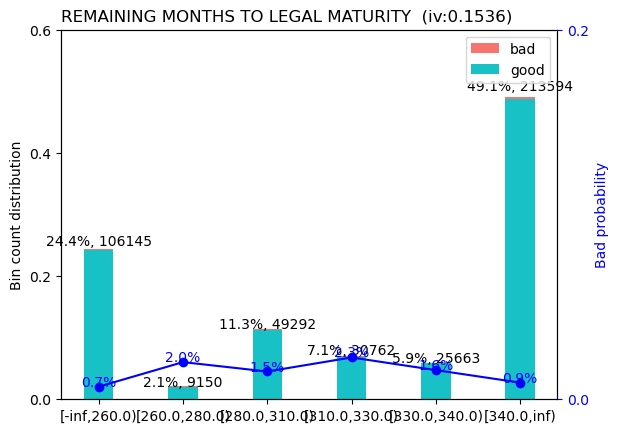

>>> Adjust breaks for (2/17) REMAINING MONTHS TO LEGAL MATURITY?
1: next 
2: yes 
3: back


Selection:  2
>>> Enter modified breaks:  280.0,300.0,320.0,330.0,340.0 


[INFO] creating woe binning ...
>>> Current breaks:
320.0, 340.0, 330.0, 300.0, 280.0 



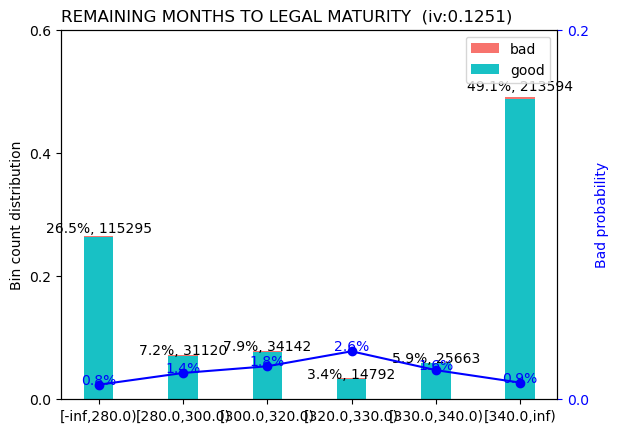

>>> Adjust breaks for (2/17) REMAINING MONTHS TO LEGAL MATURITY?
1: next 
2: yes 
3: back


Selection:  2
>>> Enter modified breaks:  280.0,300.0,320.0,330.0


[INFO] creating woe binning ...
>>> Current breaks:
300.0, 320.0, 280.0, 330.0 



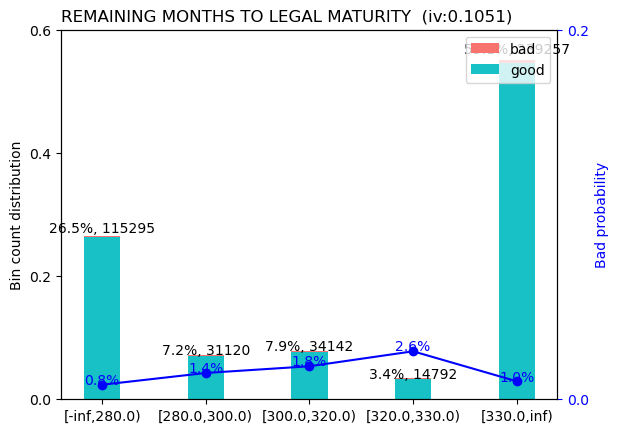

>>> Adjust breaks for (2/17) REMAINING MONTHS TO LEGAL MATURITY?
1: next 
2: yes 
3: back


Selection:  2
>>> Enter modified breaks:  280.0,300.0,320.0,340


[INFO] creating woe binning ...
>>> Current breaks:
300.0, 320.0, 340.0, 280.0 



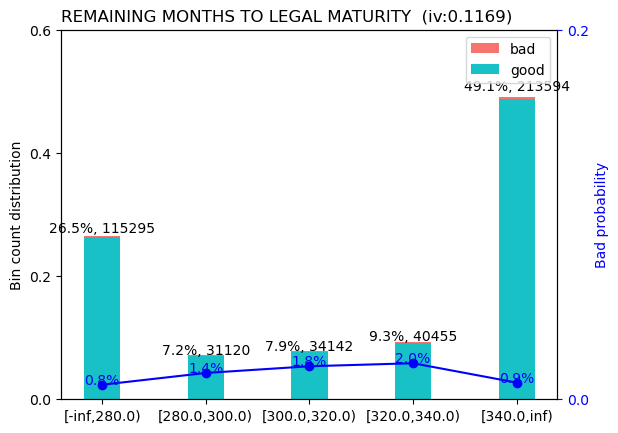

>>> Adjust breaks for (2/17) REMAINING MONTHS TO LEGAL MATURITY?
1: next 
2: yes 
3: back


Selection:  2
>>> Enter modified breaks:  280.0,300.0,320.0,340


[INFO] creating woe binning ...
>>> Current breaks:
300.0, 320.0, 340.0, 280.0 



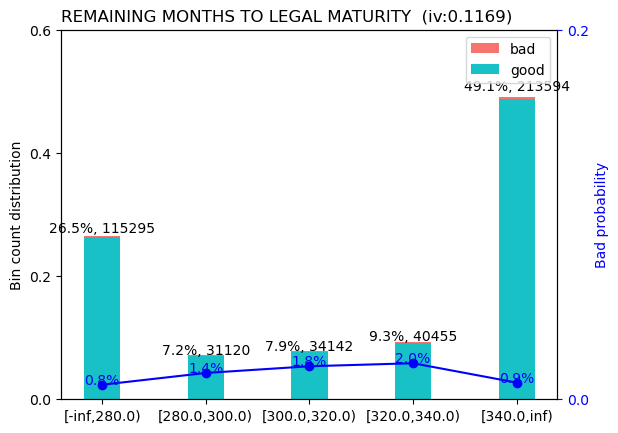

>>> Adjust breaks for (2/17) REMAINING MONTHS TO LEGAL MATURITY?
1: next 
2: yes 
3: back


Selection:  1


-------- 3/17 CREDIT SCORE --------
>>> dt[CREDIT SCORE].describe(): 
count    434573.00000
mean        753.16174
std          45.41641
min         473.00000
25%         722.00000
50%         763.00000
75%         790.00000
max         839.00000
Name: CREDIT SCORE, dtype: float64 



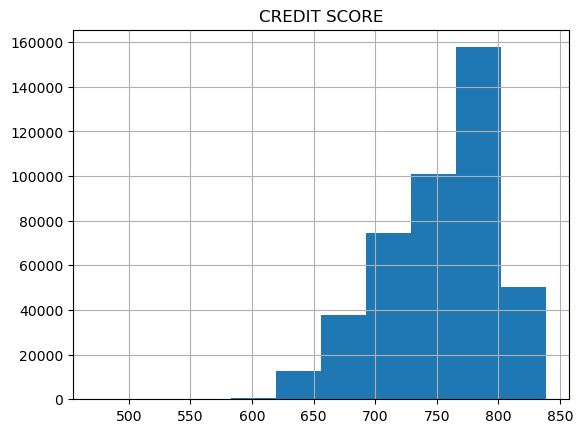

>>> Current breaks:
670.0,700.0,730.0,770.0,785.0,805.0 



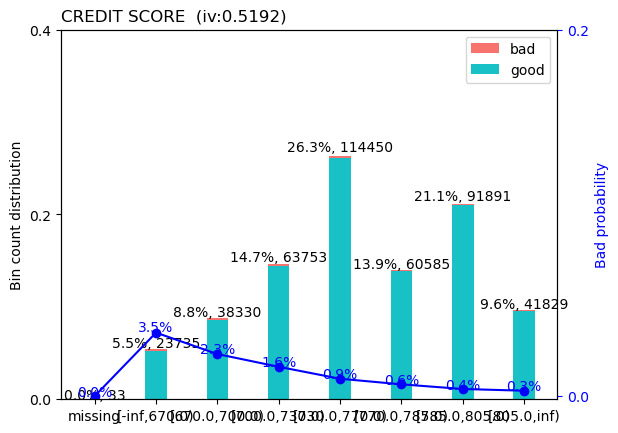

>>> Adjust breaks for (3/17) CREDIT SCORE?
1: next 
2: yes 
3: back


Selection:  1


-------- 4/17 CURRENT INTEREST RATE --------
>>> dt[CURRENT INTEREST RATE].describe(): 
count    434606.000000
mean          3.388141
std           0.737358
min           1.750000
25%           2.875000
50%           3.250000
75%           3.875000
max           6.750000
Name: CURRENT INTEREST RATE, dtype: float64 



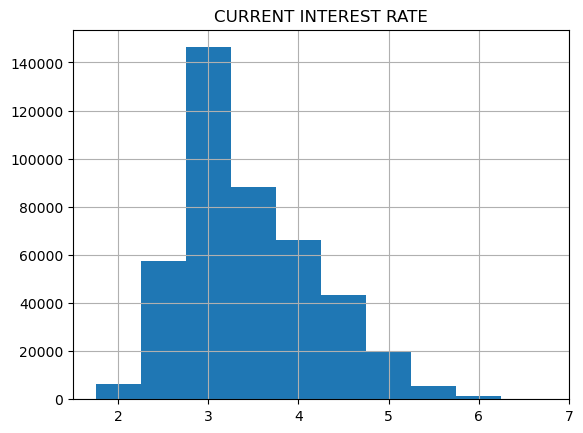

>>> Current breaks:
2.700000000000001,3.2000000000000015,3.5000000000000018,4.200000000000003,4.500000000000003 



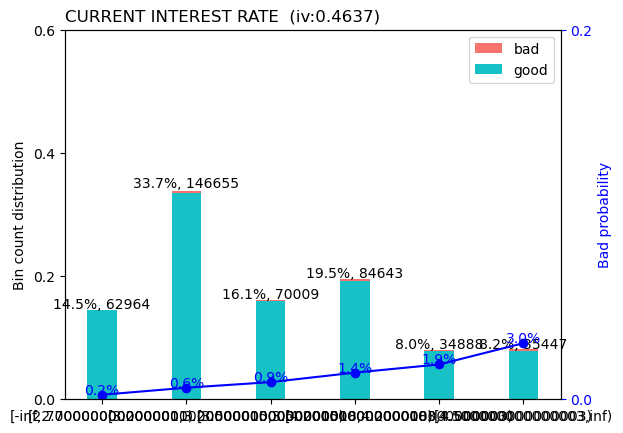

>>> Adjust breaks for (4/17) CURRENT INTEREST RATE?
1: next 
2: yes 
3: back


Selection:  1


-------- 5/17 MORTGAGE INSURANCE PERCENTAGE (MI %) --------
>>> dt[MORTGAGE INSURANCE PERCENTAGE (MI %)].describe(): 
count    434606.000000
mean          4.694245
std          10.118310
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          40.000000
Name: MORTGAGE INSURANCE PERCENTAGE (MI %), dtype: float64 



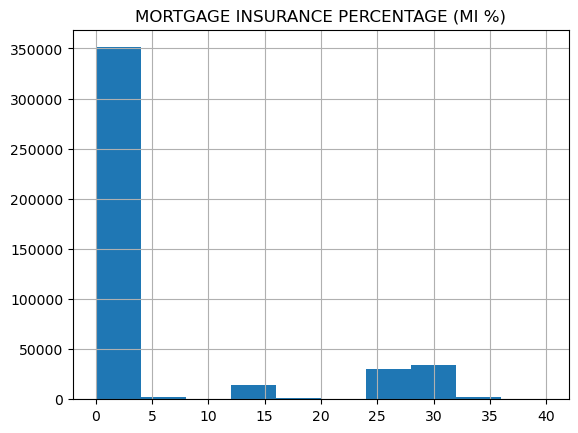

>>> Current breaks:
16.0,30.0 



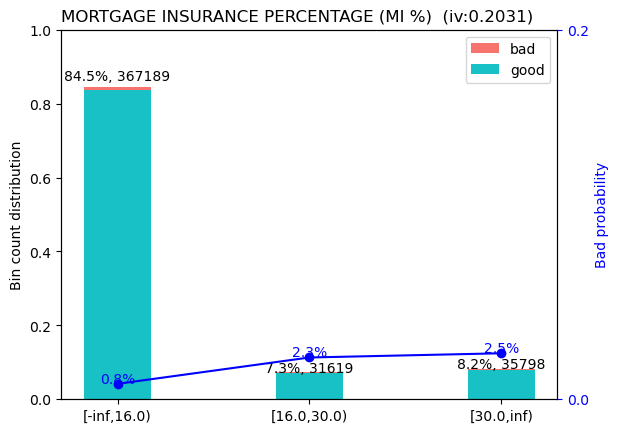

>>> Adjust breaks for (5/17) MORTGAGE INSURANCE PERCENTAGE (MI %)?
1: next 
2: yes 
3: back


Selection:  1


-------- 6/17 ORIGINAL COMBINED LOAN-TO-VALUE (CLTV) --------
>>> dt[ORIGINAL COMBINED LOAN-TO-VALUE (CLTV)].describe(): 
count    434606.000000
mean         68.722254
std          18.965328
min           3.000000
25%          57.000000
50%          72.000000
75%          80.000000
max         354.000000
Name: ORIGINAL COMBINED LOAN-TO-VALUE (CLTV), dtype: float64 



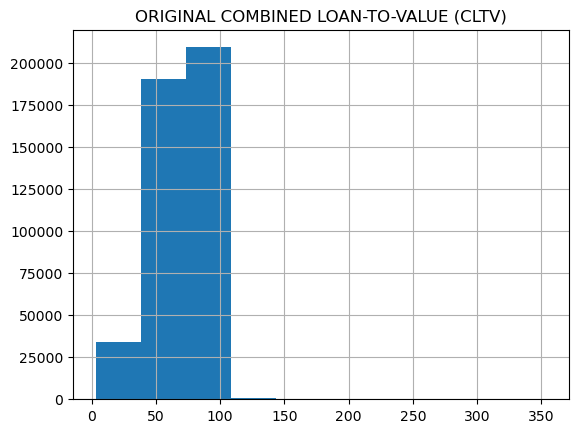

>>> Current breaks:
60.0,68.0,76.0,92.0 



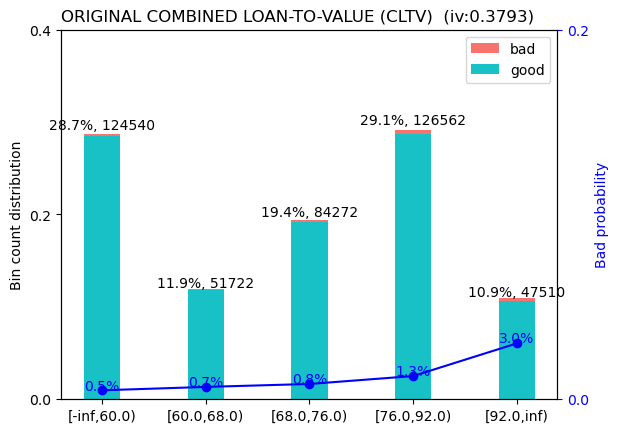

>>> Adjust breaks for (6/17) ORIGINAL COMBINED LOAN-TO-VALUE (CLTV)?
1: next 
2: yes 
3: back


Selection:  1


-------- 7/17 ORIGINAL INTEREST RATE --------
>>> dt[ORIGINAL INTEREST RATE].describe(): 
count    434606.000000
mean          3.388492
std           0.737865
min           1.750000
25%           2.875000
50%           3.250000
75%           3.875000
max           6.750000
Name: ORIGINAL INTEREST RATE, dtype: float64 



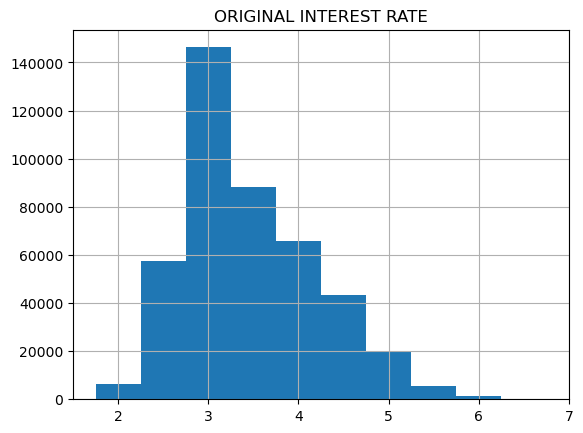

>>> Current breaks:
2.700000000000001,3.2000000000000015,3.5000000000000018,4.200000000000003,4.500000000000003 



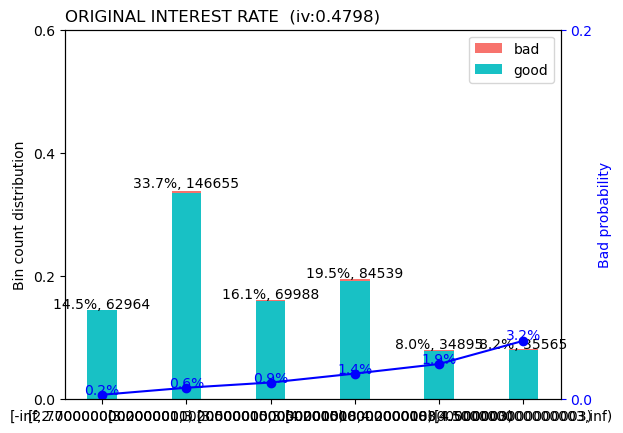

>>> Adjust breaks for (7/17) ORIGINAL INTEREST RATE?
1: next 
2: yes 
3: back


Selection:  1


-------- 8/17 CURRENT NON-INTEREST BEARING UPB --------
>>> dt[CURRENT NON-INTEREST BEARING UPB].describe(): 
count    434606.000000
mean         74.390752
std         999.045622
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      122099.260000
Name: CURRENT NON-INTEREST BEARING UPB, dtype: float64 



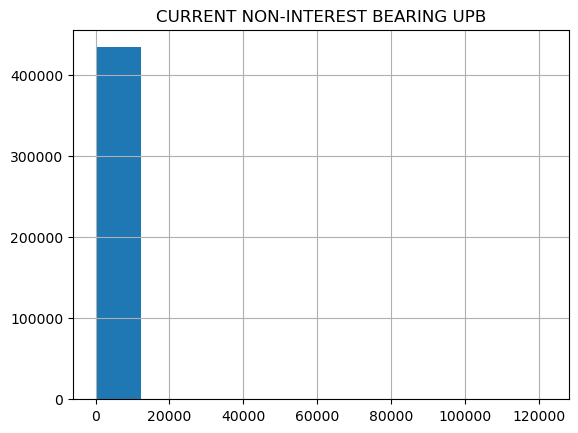

>>> Current breaks:
2000.0,4000.0 



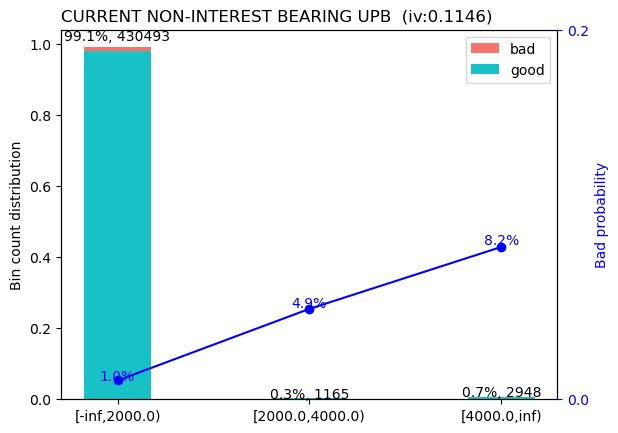

>>> Adjust breaks for (8/17) CURRENT NON-INTEREST BEARING UPB?
1: next 
2: yes 
3: back


Selection:  1


-------- 9/17 NUMBER OF UNITS --------
>>> dt[NUMBER OF UNITS].describe(): 
count    434606.000000
mean          1.030791
std           0.241113
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           4.000000
Name: NUMBER OF UNITS, dtype: float64 

>>> dt[NUMBER OF UNITS].value_counts(): 
NUMBER OF UNITS
1    425814
2      5760
4      1558
3      1474
Name: count, dtype: int64 

>>> Current breaks:
2.5,3.5 



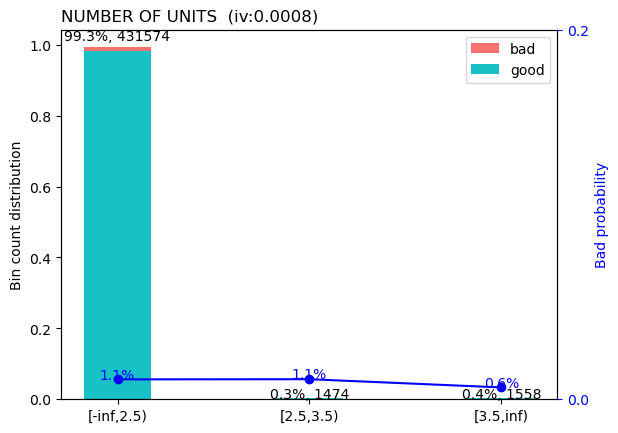

>>> Adjust breaks for (9/17) NUMBER OF UNITS?
1: next 
2: yes 
3: back


Selection:  1


-------- 10/17 ORIGINAL DEBT-TO-INCOME (DTI) RATIO --------
>>> dt[ORIGINAL DEBT-TO-INCOME (DTI) RATIO].describe(): 
count    434606.000000
mean         54.696817
std         137.001570
min           1.000000
25%          28.000000
50%          36.000000
75%          43.000000
max         999.000000
Name: ORIGINAL DEBT-TO-INCOME (DTI) RATIO, dtype: float64 



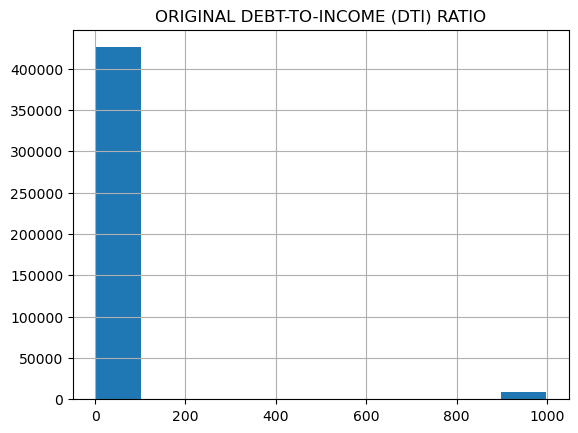

>>> Current breaks:
19.0,26.0,31.0,35.0,38.0,46.0,49.0 



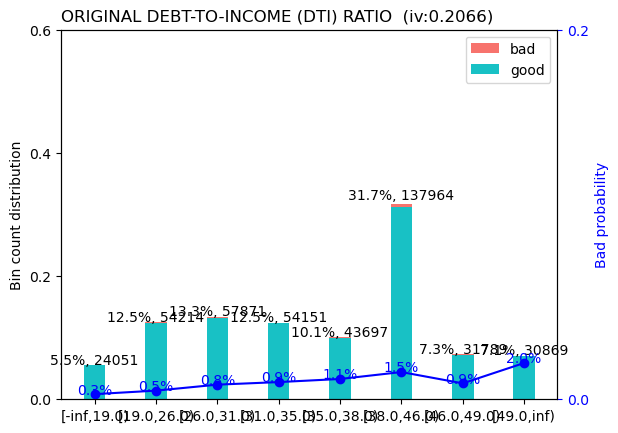

>>> Adjust breaks for (10/17) ORIGINAL DEBT-TO-INCOME (DTI) RATIO?
1: next 
2: yes 
3: back


Selection:  2
>>> Enter modified breaks:  19.0,26.0,31.0,35.0,38.0,46.0


[INFO] creating woe binning ...
>>> Current breaks:
31.0, 38.0, 19.0, 46.0, 26.0, 35.0 



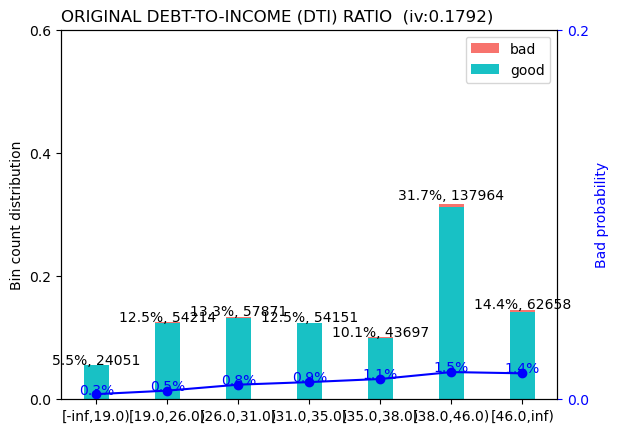

>>> Adjust breaks for (10/17) ORIGINAL DEBT-TO-INCOME (DTI) RATIO?
1: next 
2: yes 
3: back


Selection:  2
>>> Enter modified breaks:  19.0,26.0,31.0,35.0,38.0,45.0


[INFO] creating woe binning ...
>>> Current breaks:
31.0, 38.0, 45.0, 19.0, 26.0, 35.0 



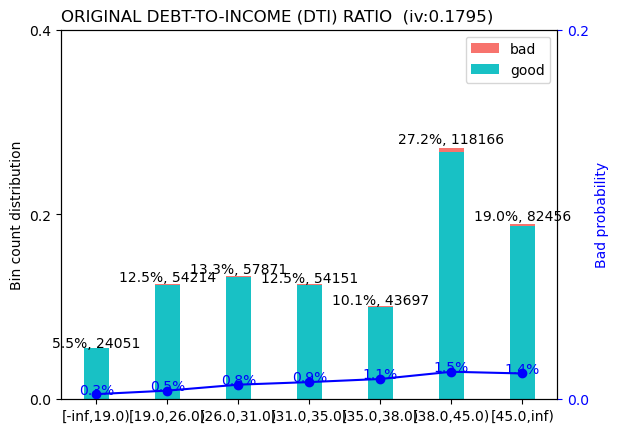

>>> Adjust breaks for (10/17) ORIGINAL DEBT-TO-INCOME (DTI) RATIO?
1: next 
2: yes 
3: back


Selection:  2
>>> Enter modified breaks:  19.0,26.0,31.0,35.0,38.0,41.0


[INFO] creating woe binning ...
>>> Current breaks:
31.0, 38.0, 19.0, 41.0, 26.0, 35.0 



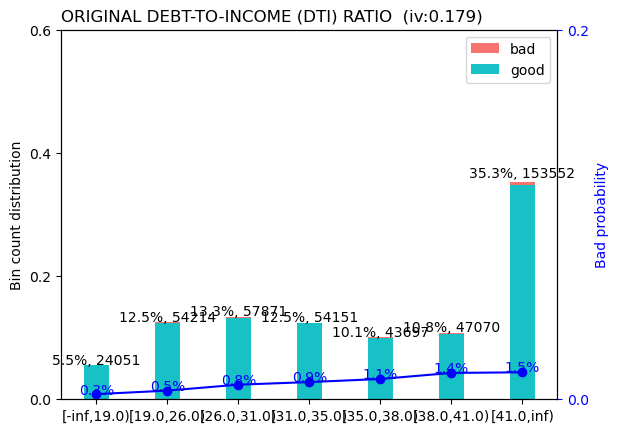

>>> Adjust breaks for (10/17) ORIGINAL DEBT-TO-INCOME (DTI) RATIO?
1: next 
2: yes 
3: back


Selection:  1


-------- 11/17 LOAN AGE --------
>>> dt[LOAN AGE].describe(): 
count    434606.000000
mean         23.696965
std          24.139313
min           0.000000
25%           6.000000
50%          13.000000
75%          36.000000
max         100.000000
Name: LOAN AGE, dtype: float64 



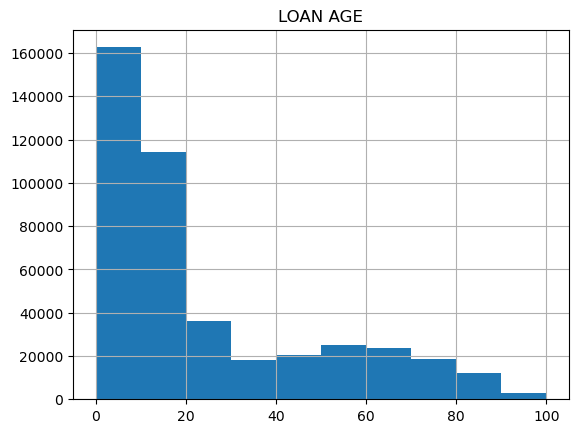

>>> Current breaks:
20.0,28.0,42.0,56.0,74.0 



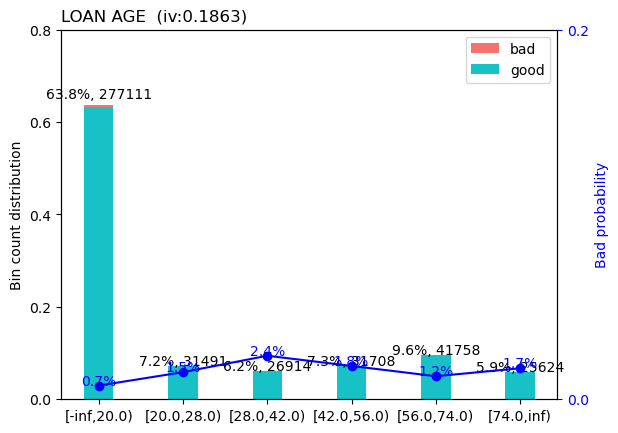

>>> Adjust breaks for (11/17) LOAN AGE?
1: next 
2: yes 
3: back


Selection:  2
>>> Enter modified breaks:  20.0,28.0,36.0,42.0


[INFO] creating woe binning ...
>>> Current breaks:
20.0, 36.0, 42.0, 28.0 



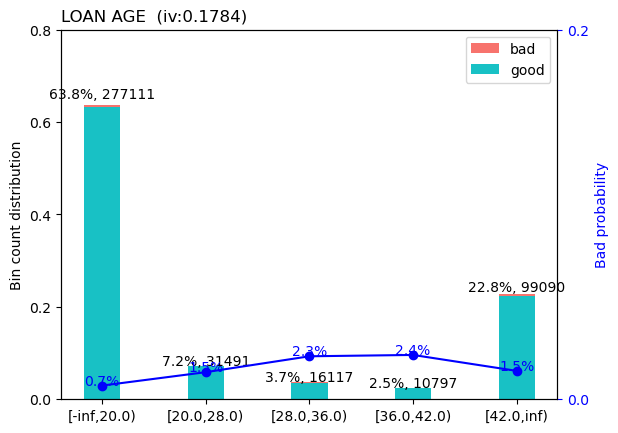

>>> Adjust breaks for (11/17) LOAN AGE?
1: next 
2: yes 
3: back


Selection:  2
>>> Enter modified breaks:  20.0, 30.0, 40.0


[INFO] creating woe binning ...
>>> Current breaks:
30.0, 40.0, 20.0 



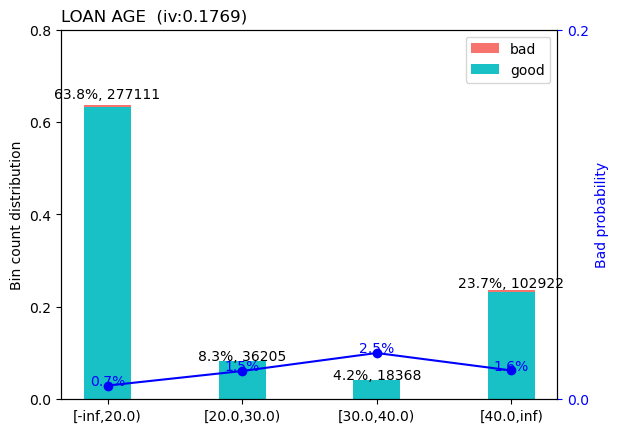

>>> Adjust breaks for (11/17) LOAN AGE?
1: next 
2: yes 
3: back


Selection:  2
>>> Enter modified breaks:  20.0, 30.0, 40.0,50.0


[INFO] creating woe binning ...
>>> Current breaks:
20.0, 30.0, 40.0, 50.0 



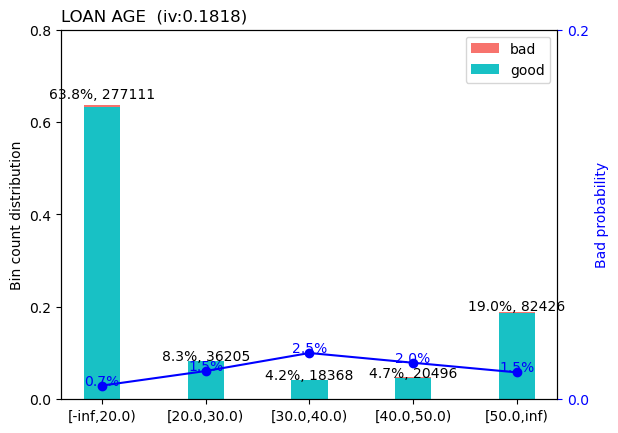

>>> Adjust breaks for (11/17) LOAN AGE?
1: next 
2: yes 
3: back


Selection:  2
>>> Enter modified breaks:  20.0, 30.0, 40.0,50.0,60


[INFO] creating woe binning ...
>>> Current breaks:
30.0, 60.0, 40.0, 50.0, 20.0 



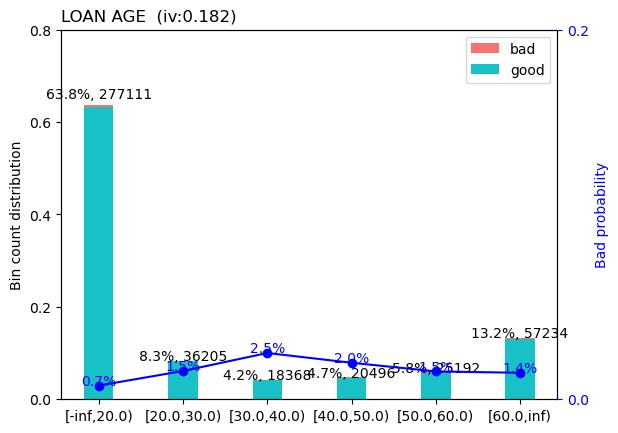

>>> Adjust breaks for (11/17) LOAN AGE?
1: next 
2: yes 
3: back


Selection:  2
>>> Enter modified breaks:  25.0, 35.0, 45.0,55.0


[INFO] creating woe binning ...
>>> Current breaks:
35.0, 45.0, 25.0, 55.0 



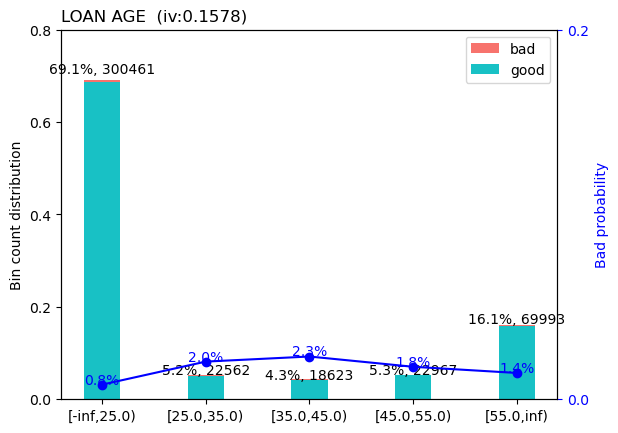

>>> Adjust breaks for (11/17) LOAN AGE?
1: next 
2: yes 
3: back


Selection:  30.0, 40.0,50


Input could not be converted to digit.


Selection:  2
>>> Enter modified breaks:  30.0, 40.0,50


[INFO] creating woe binning ...
>>> Current breaks:
30.0, 40.0, 50.0 



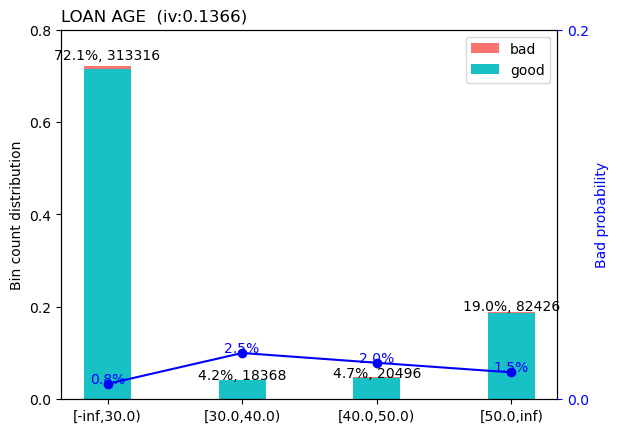

>>> Adjust breaks for (11/17) LOAN AGE?
1: next 
2: yes 
3: back


Selection:  2
>>> Enter modified breaks:  25.0, 35.0, 45.0,55.0


[INFO] creating woe binning ...
>>> Current breaks:
35.0, 45.0, 25.0, 55.0 



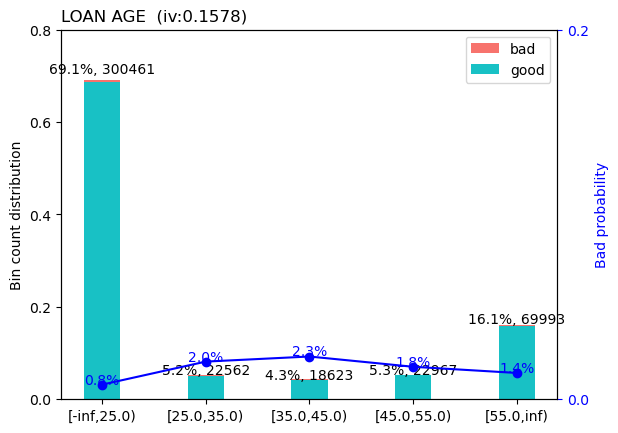

>>> Adjust breaks for (11/17) LOAN AGE?
1: next 
2: yes 
3: back


Selection:  1


-------- 12/17 ORIGINAL LOAN TERM --------
>>> dt[ORIGINAL LOAN TERM].describe(): 
count    434606.000000
mean        317.889539
std          74.169600
min          96.000000
25%         300.000000
50%         360.000000
75%         360.000000
max         501.000000
Name: ORIGINAL LOAN TERM, dtype: float64 



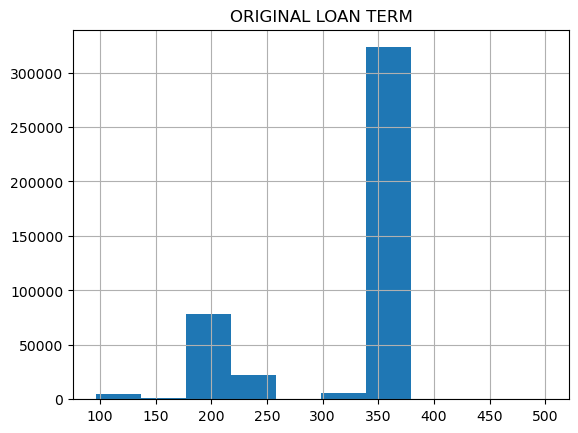

>>> Current breaks:
190.0,360.0 



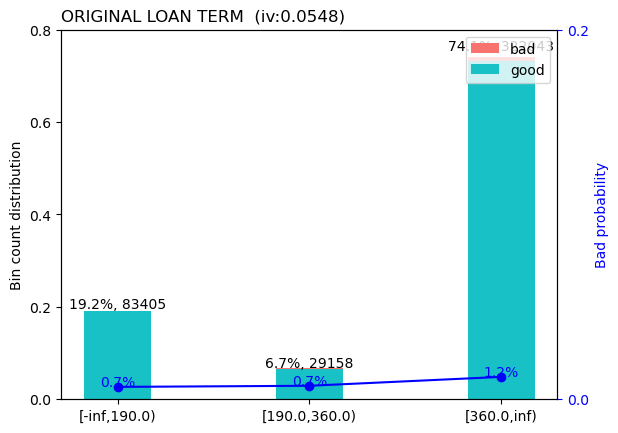

>>> Adjust breaks for (12/17) ORIGINAL LOAN TERM?
1: next 
2: yes 
3: back


Selection:  1


-------- 13/17 ESTIMATED LOAN TO VALUE (ELTV) --------
>>> dt[ESTIMATED LOAN TO VALUE (ELTV)].describe(): 
count    434606.000000
mean         97.356353
std         205.541602
min           1.000000
25%          38.000000
50%          53.000000
75%          67.000000
max         999.000000
Name: ESTIMATED LOAN TO VALUE (ELTV), dtype: float64 



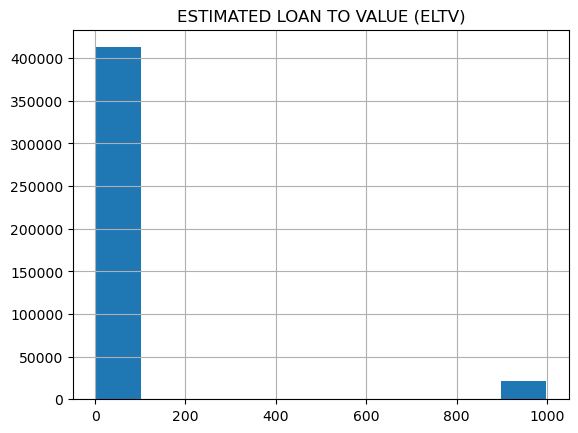

>>> Current breaks:
45.0,55.0,60.0,75.0,100.0 



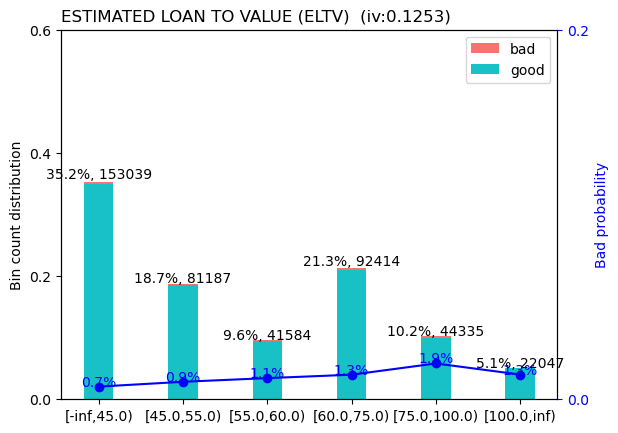

>>> Adjust breaks for (13/17) ESTIMATED LOAN TO VALUE (ELTV)?
1: next 
2: yes 
3: back


Selection:  2
>>> Enter modified breaks:  45.0,55.0,60.0,75.0


[INFO] creating woe binning ...
>>> Current breaks:
45.0, 60.0, 75.0, 55.0 



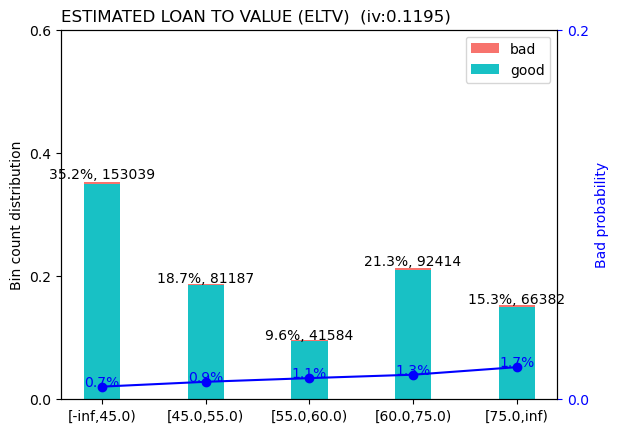

>>> Adjust breaks for (13/17) ESTIMATED LOAN TO VALUE (ELTV)?
1: next 
2: yes 
3: back


Selection:  1


-------- 14/17 CURRENT ACTUAL UPB --------
>>> dt[CURRENT ACTUAL UPB].describe(): 
count    4.346060e+05
mean     2.683163e+05
std      1.532844e+05
min      2.200000e-01
25%      1.520000e+05
50%      2.398495e+05
75%      3.559126e+05
max      1.337000e+06
Name: CURRENT ACTUAL UPB, dtype: float64 



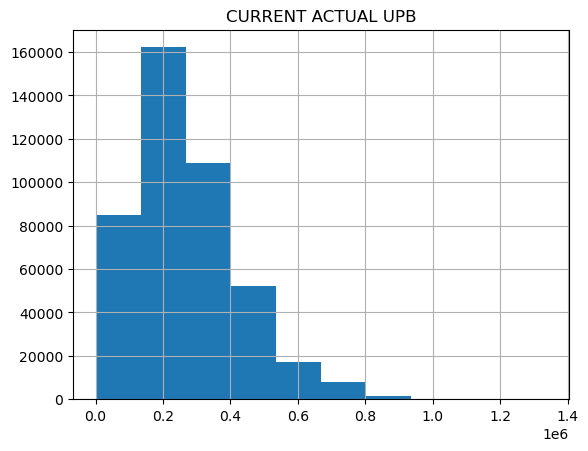

>>> Current breaks:
100000.0,140000.0,260000.0,360000.0 



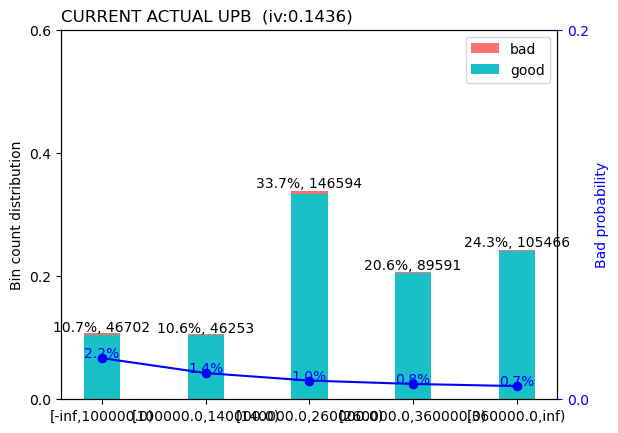

>>> Adjust breaks for (14/17) CURRENT ACTUAL UPB?
1: next 
2: yes 
3: back


Selection:  1


-------- 15/17 ORIGINAL UPB --------
>>> dt[ORIGINAL UPB].describe(): 
count    4.346060e+05
mean     2.849065e+05
std      1.522864e+05
min      1.300000e+04
25%      1.700000e+05
50%      2.560000e+05
75%      3.720000e+05
max      1.344000e+06
Name: ORIGINAL UPB, dtype: float64 



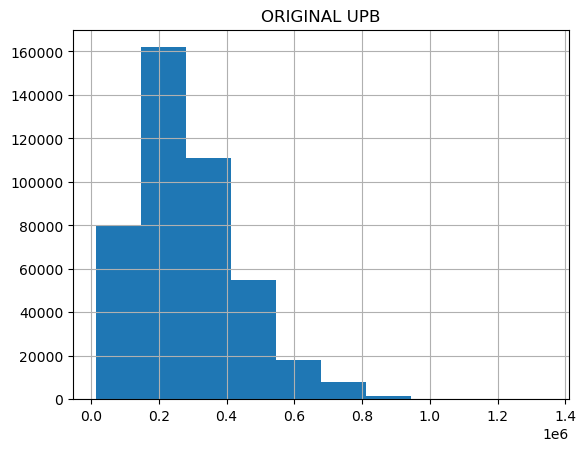

>>> Current breaks:
100000.0,160000.0,340000.0,520000.0 



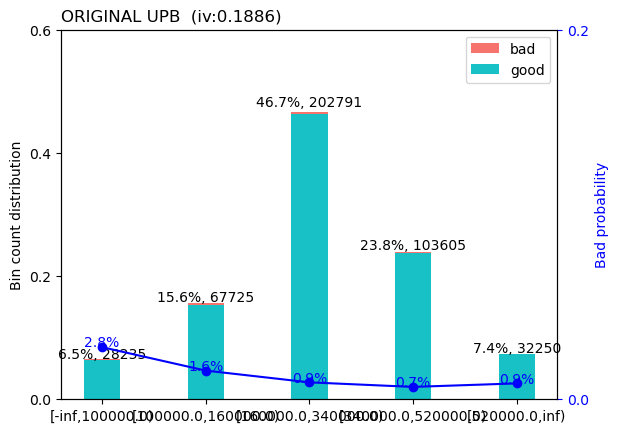

>>> Adjust breaks for (15/17) ORIGINAL UPB?
1: next 
2: yes 
3: back


Selection:  100000.0,160000.0,340000.0,500000


Input could not be converted to digit.


Selection:  2
>>> Enter modified breaks:  100000.0,160000.0,340000.0,480000


[INFO] creating woe binning ...
>>> Current breaks:
100000.0, 480000.0, 160000.0, 340000.0 



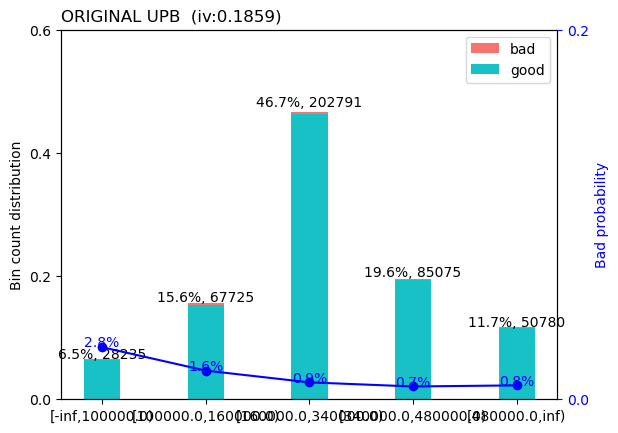

>>> Adjust breaks for (15/17) ORIGINAL UPB?
1: next 
2: yes 
3: back


Selection:  2
>>> Enter modified breaks:  100000.0,160000.0,340000.0


[INFO] creating woe binning ...
>>> Current breaks:
100000.0, 160000.0, 340000.0 



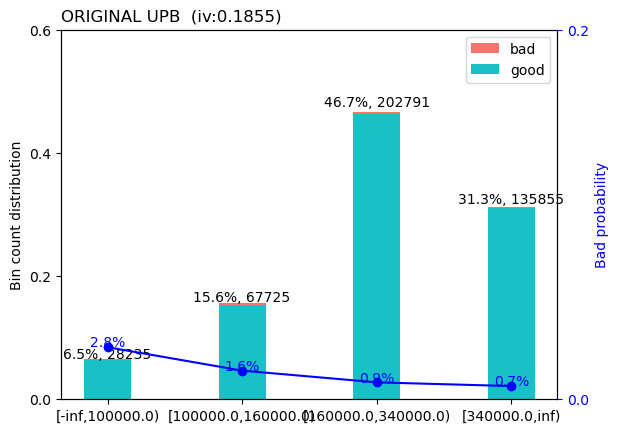

>>> Adjust breaks for (15/17) ORIGINAL UPB?
1: next 
2: yes 
3: back


Selection:  1


-------- 16/17 ORIGINAL LOAN-TO-VALUE (LTV) --------
>>> dt[ORIGINAL LOAN-TO-VALUE (LTV)].describe(): 
count    434606.000000
mean         68.412940
std          18.872357
min           3.000000
25%          57.000000
50%          72.000000
75%          80.000000
max         283.000000
Name: ORIGINAL LOAN-TO-VALUE (LTV), dtype: float64 



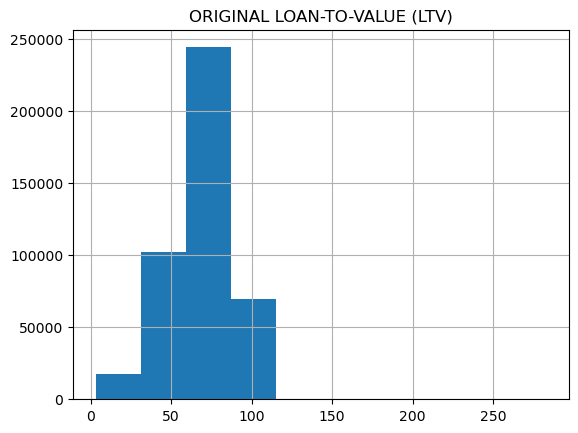

>>> Current breaks:
42.0,62.0,76.0,82.0,92.0 



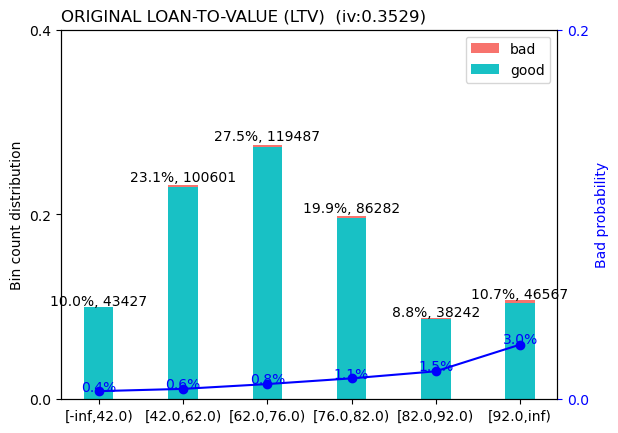

>>> Adjust breaks for (16/17) ORIGINAL LOAN-TO-VALUE (LTV)?
1: next 
2: yes 
3: back


Selection:  1


-------- 17/17 NUMBER OF BORROWERS --------
>>> dt[NUMBER OF BORROWERS].describe(): 
count    434606.000000
mean          1.475203
std           0.517078
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           4.000000
Name: NUMBER OF BORROWERS, dtype: float64 

>>> dt[NUMBER OF BORROWERS].value_counts(): 
NUMBER OF BORROWERS
1    231592
2    199898
3      2720
4       396
Name: count, dtype: int64 

>>> Current breaks:
2.0 



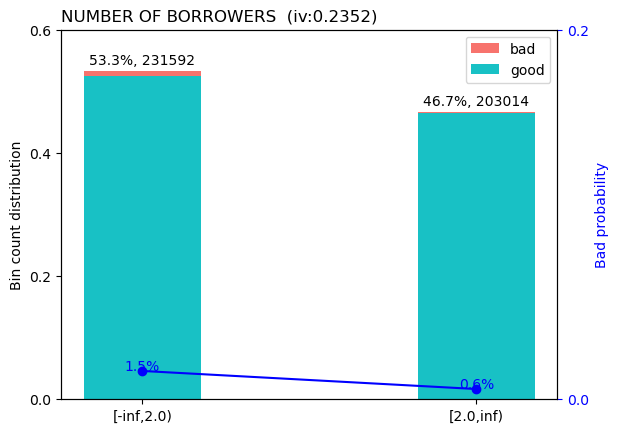

>>> Adjust breaks for (17/17) NUMBER OF BORROWERS?
1: next 
2: yes 
3: back


Selection:  2
>>> Enter modified breaks:  1.5,2.5,3.5


[INFO] creating woe binning ...
>>> Current breaks:
1.5, 3.5, 2.5 



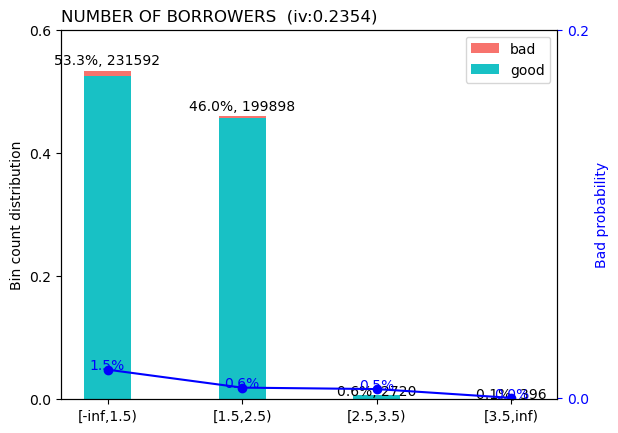

>>> Adjust breaks for (17/17) NUMBER OF BORROWERS?
1: next 
2: yes 
3: back


Selection:  1


In [38]:
breaks_adj = sc.woebin_adj(X_train_bin, "DEFAULT_NEXT_12", bins, adj_all_var=True)

In [46]:
bins_adj = sc.woebin(
    X_train_bin,
    y="DEFAULT_NEXT_12",
    breaks_list=breaks_adj 
)
train_woe = sc.woebin_ply(X_train_bin, bins_adj) # Calculate WoE dataset (train)
test_woe = sc.woebin_ply(X_train_bin, bins_adj) # Calculate WoE dataset (test)

[INFO] creating woe binning ...


/opt/anaconda3/lib/python3.12/site-packages/scorecardpy/woebin.py:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .stack().replace('missing', np.nan) \
/opt/anaconda3/lib/python3.12/site-packages/scorecardpy/woebin.py:141: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  ).groupby(['variable', 'rowid', 'bin_chr'], group_keys=False).agg({'bad':sum,'good':sum})\
/opt/anaconda3/lib/python3.12/site-packages/scorecardpy/woebin.py:141: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided calla

[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [48]:
train_woe.head()

,DEFAULT_NEXT_12,CUMULATIVE MODIFICATION COST,INTEREST BEARING UPB_woe,ORIGINAL DEBT-TO-INCOME (DTI) RATIO_woe,CREDIT SCORE_woe,CURRENT INTEREST RATE_woe,LOAN AGE_woe,REMAINING MONTHS TO LEGAL MATURITY_woe,ORIGINAL LOAN TERM_woe,MORTGAGE INSURANCE PERCENTAGE (MI %)_woe,ORIGINAL COMBINED LOAN-TO-VALUE (CLTV)_woe,ESTIMATED LOAN TO VALUE (ELTV)_woe,ORIGINAL INTEREST RATE_woe,CURRENT ACTUAL UPB_woe,ORIGINAL UPB_woe,CURRENT NON-INTEREST BEARING UPB_woe,ORIGINAL LOAN-TO-VALUE (LTV)_woe,NUMBER OF UNITS_woe,NUMBER OF BORROWERS_woe
351873,False,0.0,0.845803,-1.359054,1.193484,1.057433,0.498744,0.514599,0.120650,0.853297,1.053008,-0.129820,1.100877,0.739350,0.981274,-0.057414,1.031175,0.001439,0.358621
55630,False,0.0,0.382609,0.021192,-0.520579,-0.150237,0.284343,-0.314703,-0.477194,-0.254736,0.157040,-0.455542,-0.171944,0.279959,-0.162619,-0.057414,0.051894,0.001439,-0.664866
1457161,False,0.0,-0.409592,-0.309761,-0.128761,-0.547063,-0.307599,-0.178702,0.120650,0.853297,1.053008,0.486741,-0.547063,-0.262591,-0.412448,-0.057414,1.031175,0.001439,-0.664866
339662,False,0.0,0.382609,0.308980,-1.025527,0.569743,0.498744,0.514599,0.120650,-0.254736,-0.263873,-0.129820,0.583386,0.279959,0.371323,-0.057414,-0.269672,0.001439,-0.664866
563602,False,0.0,-0.106546,0.308980,0.402118,-0.150237,-0.307599,-0.178702,0.120650,-0.254736,0.157040,0.062855,-0.171944,-0.262591,-0.162619,-0.057414,0.051894,0.001439,-0.664866
